# Apply Gaussian Mixture Modeling (GMM) to UKESM1 ozone dataset

This example notebook contains code used to apply GMM to the UKESM1 ozone dataset.

## Initial setup

#### Import modules

We used scikit-learn (sklearn), matplotlib, pandas cartopy, and numpy

In [2]:
!pip install texttable latextable

In [3]:
#import scikit-learn
from sklearn import mixture
from sklearn import preprocessing
from sklearn import manifold
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score

# import matplotlib
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib as mpl

# import pandas, numpy, etc.
import pandas as pd
import numpy as np
import os.path
import random
import pickle
import xarray as xr
import json

# for label map
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import mpl_toolkits

# for automatic table formatting
from texttable import Texttable
import latextable



#### Set parameters

Here we select number of classes based on BIC score and manually. There are many other ways than BIC to justify choices when it comes to the number of classes.

In [4]:
# number of components (before manual grouping)
n_components_selected = 6

#saving figures
save_figs = False

# manual grouping
manual_grouping = False

# manual grouping vector
manual_classes = [0, 0, 1, 2, 3, 4, 5, 5]

# check to make sure that n_comp is as expected (uncomment this to check n_comp)
#n_comp = best_gmm.n_components

# set n_comp to manually selected value based on our further grouping
if manual_grouping==True:
    n_comp_manual = 6
    n_comp = n_comp_manual
else:
    n_comp = n_components_selected

#### Import data

Here we combine ozone profiles experiments into a single training dataset from:

     1) Historical: Annual means covering the years 2004-2014
     2) SSP1-2.6: Annual means covering the years 2090-2100 (strong emission reductions)
     3) SSP5-8.5: Annual means covering the years 2090-2100 (no emission reductions)
     
GMM will be trained on this combined dataset, such that it is exposed to the full variety of ozone states in the dataset. This will make the model more general than if it had only been trained on a single scenario. 

In [5]:
#import data
data1 = pd.read_csv('data_in/historical_seasonal.csv')
data2 = pd.read_csv('data_in/ssp126_seasonal.csv')
data3 = pd.read_csv('data_in/ssp585_seasonal.csv')
data = data1.append([data1,data2,data3], ignore_index=True) #append data
data #data load

,x,y,season,1000,925,850,700,600,500,400,...,200,150,100,70,50,30,20,10,5,1
0,0.9375,-89.375,DJF,NaN,NaN,0.000000,0.099991,1.317870,1.275637,1.339549,...,4.697723,4.587994,5.397292,8.749182,12.559555,12.841137,9.390033,4.856805,2.673725,0.204272
1,0.9375,-89.375,JJA,NaN,NaN,0.000000,0.039306,1.683980,1.477666,1.281533,...,2.541174,5.368797,10.433466,16.512575,15.625815,9.196220,6.558020,2.781719,1.010234,0.169674
2,0.9375,-89.375,MAM,NaN,NaN,0.000000,0.038577,1.336666,1.227627,1.182483,...,4.361568,5.909919,9.756591,14.610302,15.168732,10.096333,6.584430,3.567123,1.779331,0.232079
3,0.9375,-89.375,SON,NaN,NaN,0.000000,0.074782,1.541470,1.391227,1.271945,...,2.324337,4.662927,4.703378,4.604415,5.159846,6.753445,6.899643,4.422953,2.297504,0.221742
4,2.8125,-89.375,DJF,NaN,NaN,0.000000,0.098728,1.317713,1.275441,1.339394,...,4.697357,4.587856,5.396471,8.748376,12.558534,12.841625,9.391102,4.857012,2.673738,0.204271
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
442359,357.1875,89.375,MAM,3.197045,3.143483,3.110951,3.141170,3.029033,2.807894,2.675290,...,12.147468,21.561138,26.759465,26.567406,22.772397,16.389281,12.865323,7.441234,3.977507,0.346113
442360,357.1875,89.375,SON,3.264681,3.206568,3.168741,3.109062,2.952354,2.708826,2.418583,...,6.246322,10.505812,13.739154,16.610936,16.521086,12.498409,8.821268,5.321466,3.065838,0.351077
442361,359.0625,89.375,DJF,3.053687,2.911132,2.790603,2.611595,2.489740,2.283158,2.044946,...,5.133944,10.372397,17.838699,21.718482,20.744612,15.345332,11.425738,6.518369,3.296892,0.278449
442362,359.0625,89.375,JJA,3.004739,3.343178,3.626347,3.869779,3.826420,3.700889,3.470816,...,11.679680,17.567568,16.079520,16.266056,16.099107,12.749317,9.638267,5.780284,3.564140,0.263063


In [6]:
# select which pressure levels to drop 
# -- note: if you change these, you may have to re-fit the GMM
drop_levels = ['1000','925']

data1 = data1.drop(drop_levels, axis=1)
data2 = data2.drop(drop_levels, axis=1)
data3 = data3.drop(drop_levels, axis=1)
data  = data.drop(drop_levels, axis=1)
data

,x,y,season,850,700,600,500,400,300,250,200,150,100,70,50,30,20,10,5,1
0,0.9375,-89.375,DJF,0.000000,0.099991,1.317870,1.275637,1.339549,1.838563,2.986827,4.697723,4.587994,5.397292,8.749182,12.559555,12.841137,9.390033,4.856805,2.673725,0.204272
1,0.9375,-89.375,JJA,0.000000,0.039306,1.683980,1.477666,1.281533,1.196284,1.419046,2.541174,5.368797,10.433466,16.512575,15.625815,9.196220,6.558020,2.781719,1.010234,0.169674
2,0.9375,-89.375,MAM,0.000000,0.038577,1.336666,1.227627,1.182483,1.546504,2.580667,4.361568,5.909919,9.756591,14.610302,15.168732,10.096333,6.584430,3.567123,1.779331,0.232079
3,0.9375,-89.375,SON,0.000000,0.074782,1.541470,1.391227,1.271945,1.259319,1.420209,2.324337,4.662927,4.703378,4.604415,5.159846,6.753445,6.899643,4.422953,2.297504,0.221742
4,2.8125,-89.375,DJF,0.000000,0.098728,1.317713,1.275441,1.339394,1.838222,2.986227,4.697357,4.587856,5.396471,8.748376,12.558534,12.841625,9.391102,4.857012,2.673738,0.204271
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
442359,357.1875,89.375,MAM,3.110951,3.141170,3.029033,2.807894,2.675290,3.322640,5.470188,12.147468,21.561138,26.759465,26.567406,22.772397,16.389281,12.865323,7.441234,3.977507,0.346113
442360,357.1875,89.375,SON,3.168741,3.109062,2.952354,2.708826,2.418583,2.479093,3.285944,6.246322,10.505812,13.739154,16.610936,16.521086,12.498409,8.821268,5.321466,3.065838,0.351077
442361,359.0625,89.375,DJF,2.790603,2.611595,2.489740,2.283158,2.044946,2.079820,2.728039,5.133944,10.372397,17.838699,21.718482,20.744612,15.345332,11.425738,6.518369,3.296892,0.278449
442362,359.0625,89.375,JJA,3.626347,3.869779,3.826420,3.700889,3.470816,3.705905,5.447102,11.679680,17.567568,16.079520,16.266056,16.099107,12.749317,9.638267,5.780284,3.564140,0.263063


#### Set aside unmodified original dataset, extract ozone values, longitudes, latitudes, and seasons

Pressures are in hPa (vertical coordinate), latitudes and longitudes are in degrees, and ozone concentrations are in mPa.

In [7]:
# keep 'data' as the unmodified original
data_cleaned = data

# drop rows (profiles) with NaNs
data_cleaned = data_cleaned.dropna()
data_cleaned = data_cleaned.reset_index(drop=True)

# extract pressure values from the column headers
p = data_cleaned.columns[3:].values

# let's work with the cleaned up dataset
df = data_cleaned

# get the latitudes, and longitudes for each profile
lon = df.iloc[:,0].values
lat = df.iloc[:,1].values
season = df.iloc[:,2].values

# get the array that will be used to fit the GMM object
X = df.iloc[:,3:].values

# count the number of profiles in the full, combined dataset
nProfiles = X[:,1].size

# examine df (dataframe) 
df

,x,y,season,850,700,600,500,400,300,250,200,150,100,70,50,30,20,10,5,1
0,0.9375,-89.375,DJF,0.000000,0.099991,1.317870,1.275637,1.339549,1.838563,2.986827,4.697723,4.587994,5.397292,8.749182,12.559555,12.841137,9.390033,4.856805,2.673725,0.204272
1,0.9375,-89.375,JJA,0.000000,0.039306,1.683980,1.477666,1.281533,1.196284,1.419046,2.541174,5.368797,10.433466,16.512575,15.625815,9.196220,6.558020,2.781719,1.010234,0.169674
2,0.9375,-89.375,MAM,0.000000,0.038577,1.336666,1.227627,1.182483,1.546504,2.580667,4.361568,5.909919,9.756591,14.610302,15.168732,10.096333,6.584430,3.567123,1.779331,0.232079
3,0.9375,-89.375,SON,0.000000,0.074782,1.541470,1.391227,1.271945,1.259319,1.420209,2.324337,4.662927,4.703378,4.604415,5.159846,6.753445,6.899643,4.422953,2.297504,0.221742
4,2.8125,-89.375,DJF,0.000000,0.098728,1.317713,1.275441,1.339394,1.838222,2.986227,4.697357,4.587856,5.396471,8.748376,12.558534,12.841625,9.391102,4.857012,2.673738,0.204271
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
428078,357.1875,89.375,MAM,3.110951,3.141170,3.029033,2.807894,2.675290,3.322640,5.470188,12.147468,21.561138,26.759465,26.567406,22.772397,16.389281,12.865323,7.441234,3.977507,0.346113
428079,357.1875,89.375,SON,3.168741,3.109062,2.952354,2.708826,2.418583,2.479093,3.285944,6.246322,10.505812,13.739154,16.610936,16.521086,12.498409,8.821268,5.321466,3.065838,0.351077
428080,359.0625,89.375,DJF,2.790603,2.611595,2.489740,2.283158,2.044946,2.079820,2.728039,5.133944,10.372397,17.838699,21.718482,20.744612,15.345332,11.425738,6.518369,3.296892,0.278449
428081,359.0625,89.375,JJA,3.626347,3.869779,3.826420,3.700889,3.470816,3.705905,5.447102,11.679680,17.567568,16.079520,16.266056,16.099107,12.749317,9.638267,5.780284,3.564140,0.263063


In [8]:
p = data_cleaned.columns[3:].values
p

array(['850', '700', '600', '500', '400', '300', '250', '200', '150',
       '100', '70', '50', '30', '20', '10', '5', '1'], dtype=object)

## Preprocessing: principal component analysis 

Here we carry out PCA for dimensionality reduction

#### Standardise the data

In [9]:
Xscaled = preprocessing.scale(X) #scaling

#### Use PCA for dimensionality reduction

In [10]:
# create PCA object
pca = PCA(n_components=8)

# fit PCA model
pca.fit(Xscaled)

# transform input data into PCA representation
Xpca = pca.transform(Xscaled)

# calculated total variance explained
total_variance_explained_ = np.sum(pca.explained_variance_ratio_) 
total_variance_explained_

0.9885760933932283

In [11]:
pca

PCA(n_components=8)

Visualizing the eigenfunctions

In [12]:
#ploting the eigenfunctions
y = pca.components_
y1 = y[:,:]

#orginal pressure levels
z = data_cleaned.columns[3:].values

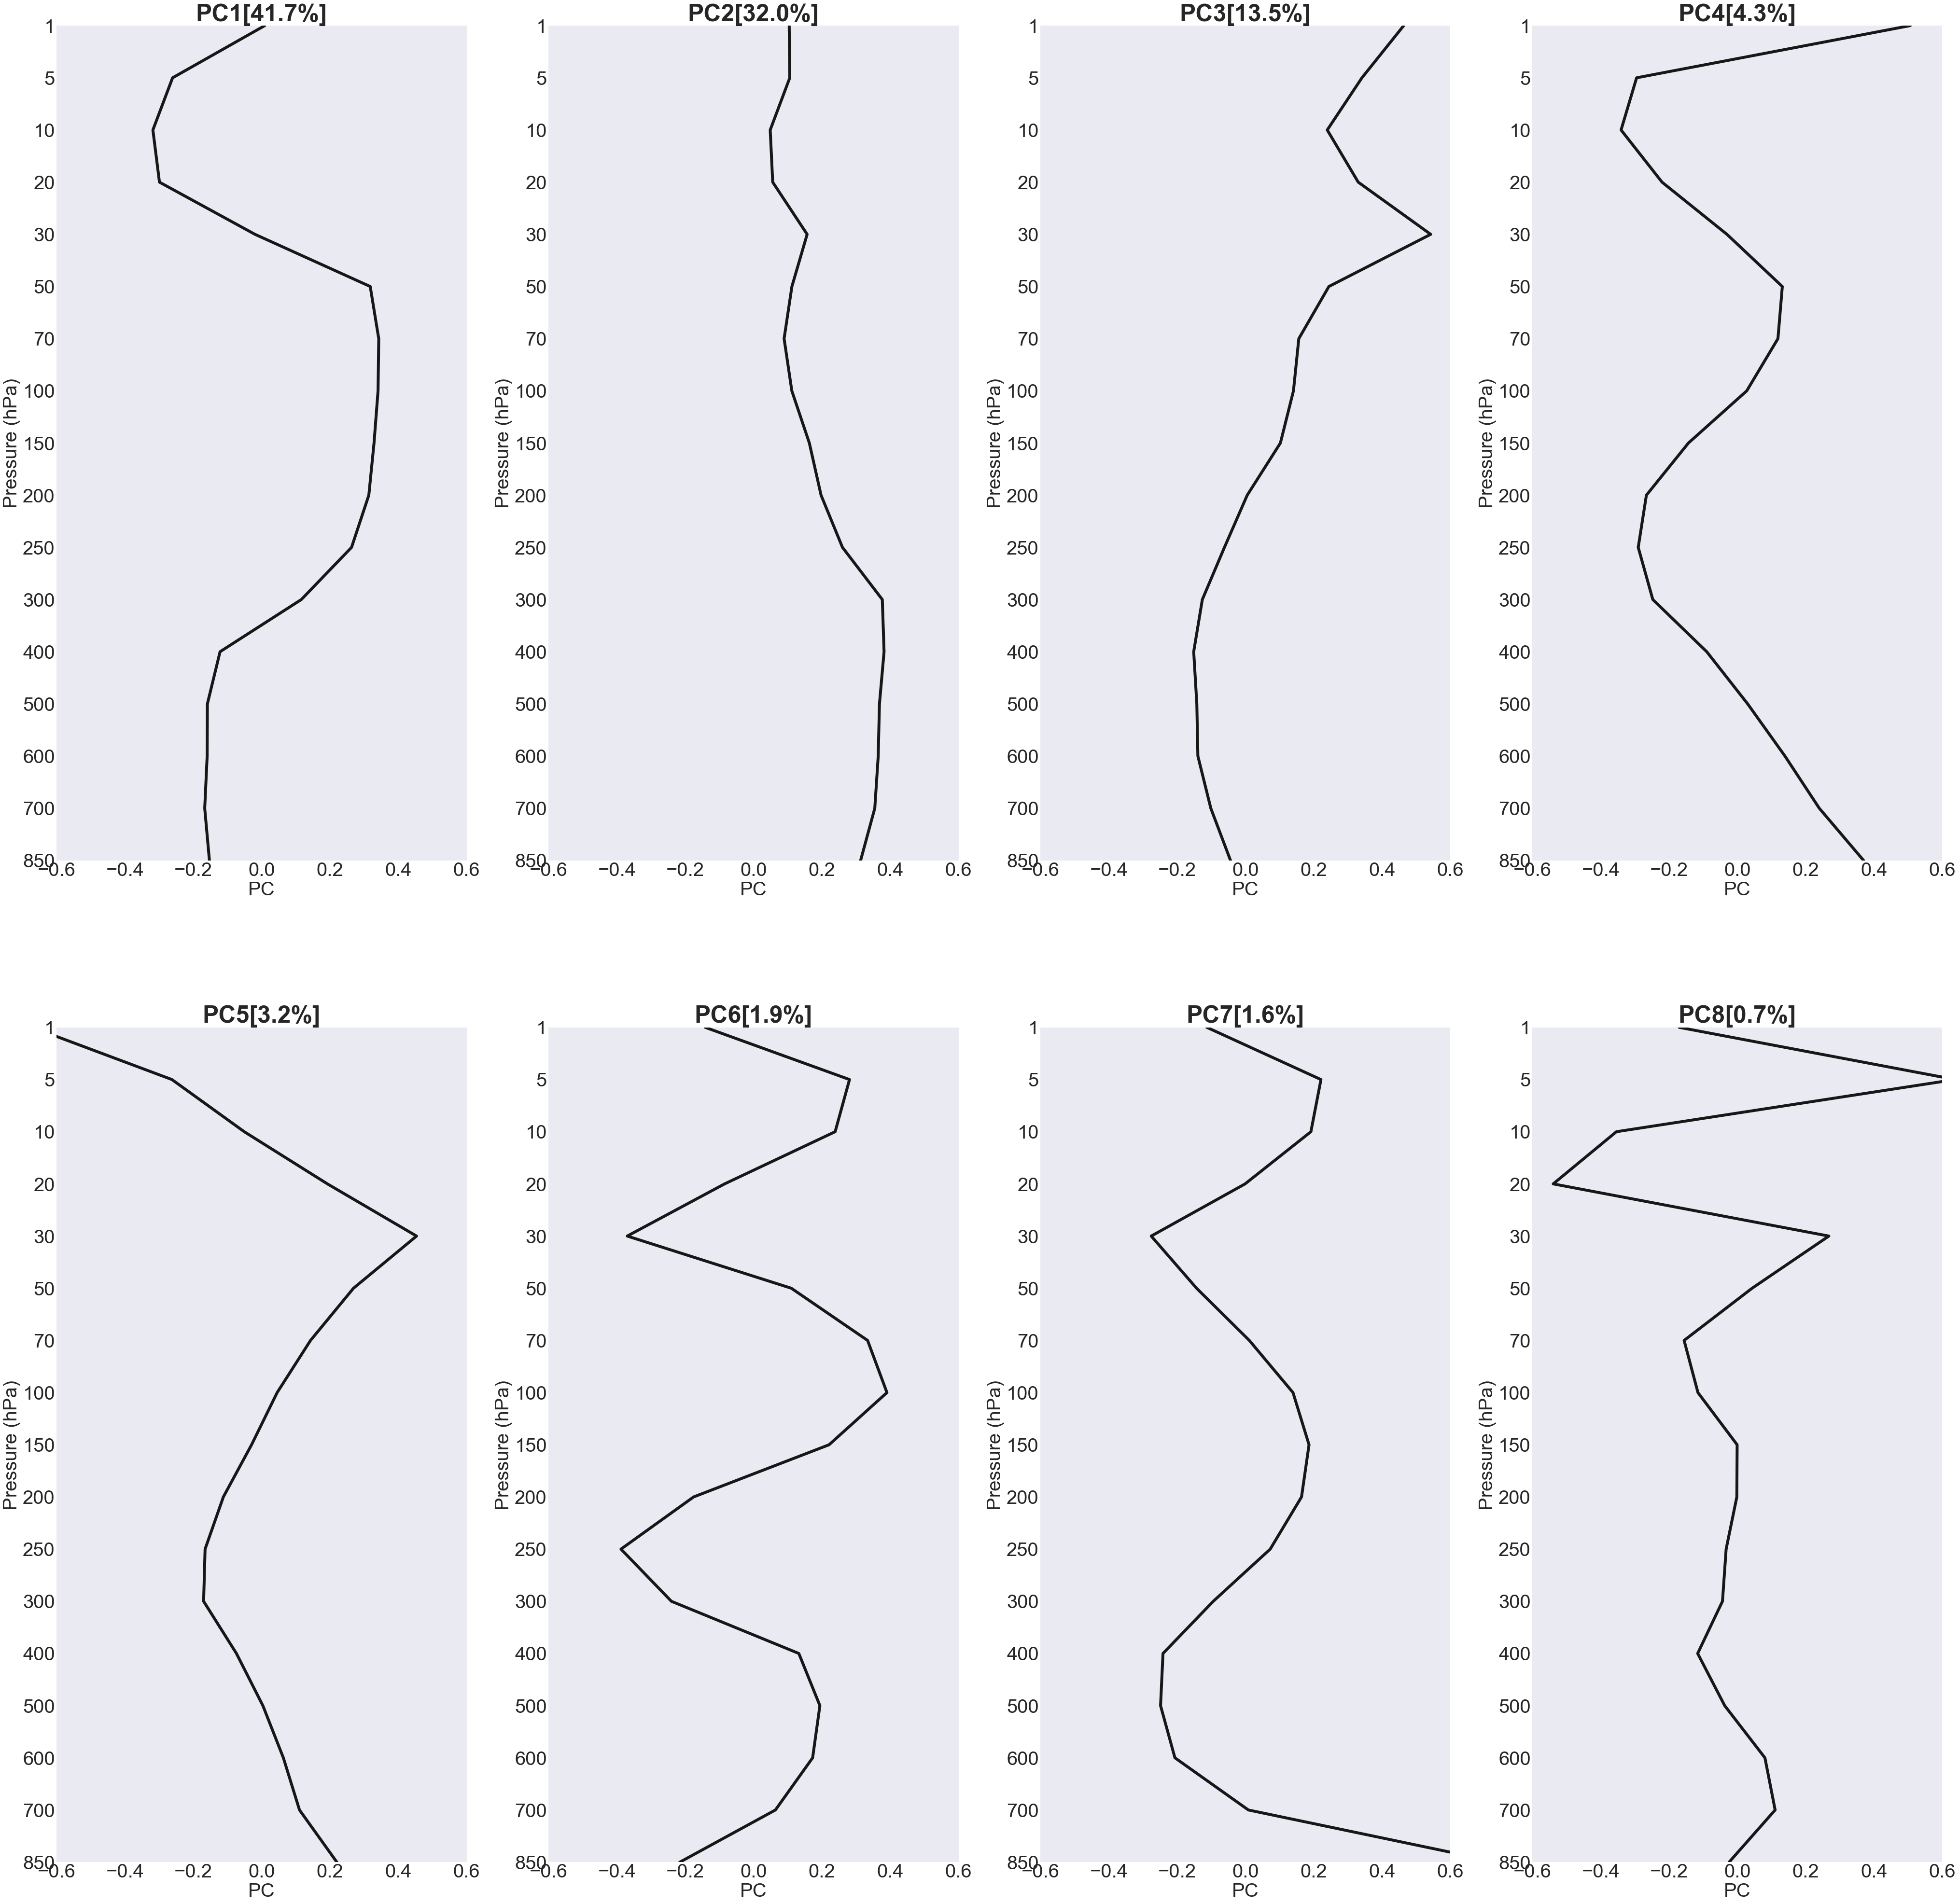

In [13]:
plt.figure(figsize = (70,70))
plt.style.use('seaborn-darkgrid')

num = 0

# iterate over groups
for npca in range(pca.n_components):
    num = num + 1
    
    # select subplot
    ax = plt.subplot(2,4,num)
    plt.plot(y1[npca,:], z, marker='', linestyle='solid',
                 color='black', linewidth=6.0, alpha=0.9)
    
    # custom grid and axes
    plt.grid()
    plt.ylim([min(z), z[0]])
    plt.xlim([-.6, .6])
    #text box
    fs = 24 # font size

    plt.xlabel('PC', fontsize=40)
    plt.ylabel('Pressure (hPa)', fontsize=40)
    plt.title('PC' + str(npca+1) + \
              '[' + str(round(pca.explained_variance_ratio_[npca]*100,1)) + '%]', fontsize=50, fontweight="bold")
              
                  
    # font and axis stuff
    plt.gca().invert_yaxis()
    ax.tick_params(axis='x', labelsize=40)
    ax.tick_params(axis='y', labelsize=40)
    # save figure and close
    #plt.savefig("figures/pca.pdf", bbox_inches='tight',dpi=300)

#### Finding minimum BIC score for best Gaussian mixture model

In [14]:
# if file exists, then load it. Otherwise, calculate best GMM model
#mloc = '../../src/models/'
if os.path.isfile( 'models/n' + str(n_components_selected) + 'best_gmm_means.npy'):

    # set gmm_loaded flag to true
    gmm_loaded = True
    print('Found a GMM file, loading pre-fit GMM')
    
    # reload
    gmm_name = 'models/n' + str(n_components_selected) + 'best_gmm'
    means = np.load(gmm_name + '_means.npy')
    covar = np.load(gmm_name + '_covariances.npy')
    loaded_gmm = mixture.GaussianMixture(n_components = len(means), covariance_type='full')
    loaded_gmm.precisions_cholesky_ = np.linalg.cholesky(np.linalg.inv(covar))
    loaded_gmm.weights_ = np.load(gmm_name + '_weights.npy')
    loaded_gmm.means_ = means
    loaded_gmm.covariances_ = covar
    best_gmm = loaded_gmm

else:
    
    # set gmm_loaded flag to true
    gmm_loaded = False
    
    # select parameters
    max_N = 30     # the maximum number of classes to try 
    max_bic_iter = 20  # the maximum number of iterations for BIC

    # initialise, declare variables
    lowest_bic = np.infty
    lowest_aic = np.infty
    bic_scores = np.zeros((2,max_bic_iter))
    aic_scores = np.zeros((2,max_bic_iter))
    silhouette_scores = np.zeros((2,max_bic_iter))

    # loop through the maximum number of classes, estimate BIC
    n_components_range = range(2, max_N)
    bic_iter_range = range(0,max_bic_iter)
    aic_iter_range = range(0,max_bic_iter)
    
    # iterate through all the covariance types (just 'full' for now)
    cv_types = ['full']
    
    for cv_type in cv_types:
        # iterate over all the possible numbers of components
        for n_components in n_components_range:
            
            # empty BIC and silhouette arrays
            bic_one = []
            aic_one = []
            sil_one = []
            
            # repeat the BIC step for better statistics
            for bic_iter in bic_iter_range:
                
                # select a new random subset
                rows_id = random.sample(range(0,Xpca.shape[0]-1), 1000)
                Xpca_for_BIC = Xpca[rows_id,:]
                
                # fit a Gaussian mixture model
                gmm = mixture.GaussianMixture(n_components=n_components,
                                              covariance_type=cv_type,
                                              random_state=42)

                # uncomment for 'rapid' BIC fitting
                gmm.fit(Xpca_for_BIC)
                # uncomment for 'full' BIC fitting
                #gmm.fit(Xpca)
                # append this BIC score to the list
                bic_one.append(gmm.bic(Xpca_for_BIC))
                aic_one.append(gmm.aic(Xpca_for_BIC))
                
                # get labels and silhouette score
                # The silhouette_score gives the average value for all the samples.
                # This gives a perspective into the density and separation of the formed
                # clusters
                cluster_labels_tmp = gmm.predict(Xpca_for_BIC)
                sil_tmp = silhouette_score(Xpca_for_BIC, cluster_labels_tmp)
                sil_one.append(sil_tmp)
                
                # clear this for the next BIC iteration
                Xpca_for_BIC = []
                
            # stack the bic and silhouette scores into a single 2D structure
            bic_scores = np.vstack((bic_scores, np.asarray(bic_one)))
            aic_scores = np.vstack((aic_scores, np.asarray(aic_one)))
            silhouette_scores = np.vstack((silhouette_scores, np.asarray(sil_one)))

    # BIC plot ----------------
            
    # the first two rows are not needed; they were only placeholders
    bic_scores = bic_scores[2:,:]

    # mean values for BIC
    bic_mean = np.mean(bic_scores, axis=1)

    # standard deviation for BIC
    bic_std = np.std(bic_scores, axis=1)

    # examine the mean bic values
    #bic_mean

    # plot the BIC scores
    plt.figure(figsize=(20, 8))
    plt.style.use('seaborn-darkgrid')
    spl = plt.subplot(2, 1, 1)
    plt.plot(n_components_range, bic_mean-bic_std, '--')  
    plt.plot(n_components_range, bic_mean, '-')  
    plt.plot(n_components_range, bic_mean+bic_std, '--')  
    plt.xticks(n_components_range)
    #plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
    plt.title('BIC score per model', fontsize=18)
    spl.set_xlabel('Number of components',fontsize=18)
    spl.set_ylabel('BIC score',fontsize=18)
    #plt.show()

    # save figure
    #plt.savefig(ploc+"BIC score per model (UKESM)",
    #           bbox_inches="tight",transparent=False)
    
    # AIC plot ----------------
            
    # the first two rows are not needed; they were only placeholders
    aic_scores = aic_scores[2:,:]

    # mean values for AIC
    aic_mean = np.mean(aic_scores, axis=1)

    # standard deviation for AIC
    aic_std = np.std(aic_scores, axis=1)

    # plot the AIC scores
    plt.figure(figsize=(20, 8))
    plt.style.use('seaborn-darkgrid')
    spl = plt.subplot(2, 1, 1)
    plt.plot(n_components_range, aic_mean-aic_std, '--')  
    plt.plot(n_components_range, aic_mean, '-')  
    plt.plot(n_components_range, aic_mean+aic_std, '--')  
    plt.xticks(n_components_range)
    #plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
    plt.title('AIC score per model', fontsize=18)
    spl.set_xlabel('Number of components',fontsize=18)
    spl.set_ylabel('AIC score',fontsize=18)
    #plt.show()

    # save figure
    #plt.savefig(ploc+"AIC score per model",
    #           bbox_inches="tight",transparent=False)
    
    # Silhouette score plot ----------------
            
    # the first two rows are not needed; they were only placeholders
    silhouette_scores = silhouette_scores[2:,:]

    # mean values for silhouette
    silhouette_mean = np.mean(silhouette_scores, axis=1)

    # standard deviation for silhouette
    silhouette_std = np.std(silhouette_scores, axis=1)

    # plot the silhouette scores
    plt.figure(figsize=(20, 8))
    plt.style.use('seaborn-darkgrid')
    spl = plt.subplot(2, 1, 1)
    plt.plot(n_components_range, silhouette_mean-silhouette_std, '--')  
    plt.plot(n_components_range, silhouette_mean, '-')  
    plt.plot(n_components_range, silhouette_mean+silhouette_std, '--')  
    plt.xticks(n_components_range)
    plt.title('Silhouette width per model', fontsize=18)
    spl.set_xlabel('Number of components',fontsize=18)
    spl.set_ylabel('Silhouette width',fontsize=18)

Found a GMM file, loading pre-fit GMM


In [15]:
# if the file exists, it should already be loaded. Print it out. 
if gmm_loaded==True:
    
    # print out best_gmm
    print('GMM has been pre-fit and it already loaded')
    best_gmm
    
else:
    
    # fit the "best" GMM model using the full Xpca dataset
    best_gmm = mixture.GaussianMixture(n_components=n_components_selected, 
                                       covariance_type='full', 
                                       random_state=42)
    best_gmm.fit(Xpca)
    # save to file
    gmm_name = 'models/n' + str(n_components_selected) + 'best_gmm' 
    np.save(gmm_name + '_weights', best_gmm.weights_, allow_pickle=False)
    np.save(gmm_name + '_means', best_gmm.means_, allow_pickle=False)
    np.save(gmm_name + '_covariances', best_gmm.covariances_, allow_pickle=False)

    
best_gmm

GMM has been pre-fit and it already loaded


GaussianMixture(n_components=6)

In [16]:
# assign class labels ("predict" the class using the selected GMM)
labels = best_gmm.predict(Xpca)

# find posterior probabilities (the probabilities of belonging to each class)
posterior_probs = best_gmm.predict_proba(Xpca)

# maximum posterior probability (the class is assigned based on this value)
max_posterior_probs = np.max(posterior_probs,axis=1) 

# put the labels and maximum posterior probabilities back in original dataframe
df.insert(3,'label',labels,True)
df.insert(4,'max posterior prob',max_posterior_probs,True) 

# print out best_gmm parameters
df

,x,y,season,label,max posterior prob,850,700,600,500,400,...,200,150,100,70,50,30,20,10,5,1
0,0.9375,-89.375,DJF,4,1.000000,0.000000,0.099991,1.317870,1.275637,1.339549,...,4.697723,4.587994,5.397292,8.749182,12.559555,12.841137,9.390033,4.856805,2.673725,0.204272
1,0.9375,-89.375,JJA,4,1.000000,0.000000,0.039306,1.683980,1.477666,1.281533,...,2.541174,5.368797,10.433466,16.512575,15.625815,9.196220,6.558020,2.781719,1.010234,0.169674
2,0.9375,-89.375,MAM,4,1.000000,0.000000,0.038577,1.336666,1.227627,1.182483,...,4.361568,5.909919,9.756591,14.610302,15.168732,10.096333,6.584430,3.567123,1.779331,0.232079
3,0.9375,-89.375,SON,4,1.000000,0.000000,0.074782,1.541470,1.391227,1.271945,...,2.324337,4.662927,4.703378,4.604415,5.159846,6.753445,6.899643,4.422953,2.297504,0.221742
4,2.8125,-89.375,DJF,4,1.000000,0.000000,0.098728,1.317713,1.275441,1.339394,...,4.697357,4.587856,5.396471,8.748376,12.558534,12.841625,9.391102,4.857012,2.673738,0.204271
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
428078,357.1875,89.375,MAM,5,1.000000,3.110951,3.141170,3.029033,2.807894,2.675290,...,12.147468,21.561138,26.759465,26.567406,22.772397,16.389281,12.865323,7.441234,3.977507,0.346113
428079,357.1875,89.375,SON,2,1.000000,3.168741,3.109062,2.952354,2.708826,2.418583,...,6.246322,10.505812,13.739154,16.610936,16.521086,12.498409,8.821268,5.321466,3.065838,0.351077
428080,359.0625,89.375,DJF,5,0.999994,2.790603,2.611595,2.489740,2.283158,2.044946,...,5.133944,10.372397,17.838699,21.718482,20.744612,15.345332,11.425738,6.518369,3.296892,0.278449
428081,359.0625,89.375,JJA,2,1.000000,3.626347,3.869779,3.826420,3.700889,3.470816,...,11.679680,17.567568,16.079520,16.266056,16.099107,12.749317,9.638267,5.780284,3.564140,0.263063


In [17]:
# group by label
grouped_unsorted = df.groupby('label')

# calculate mean of all profiles in each class
df_means = grouped_unsorted.mean()
oz_means = df_means['y'].values
old2new = np.argsort(oz_means)

# create dictionary object for sorting
di = dict(zip(old2new,range(0,n_components_selected)))

# add new column to dataframe - sorted label
df.insert(4,'label_sorted',df['label'].map(di))

# examine dataframe
df

,x,y,season,label,label_sorted,max posterior prob,850,700,600,500,...,200,150,100,70,50,30,20,10,5,1
0,0.9375,-89.375,DJF,4,0,1.000000,0.000000,0.099991,1.317870,1.275637,...,4.697723,4.587994,5.397292,8.749182,12.559555,12.841137,9.390033,4.856805,2.673725,0.204272
1,0.9375,-89.375,JJA,4,0,1.000000,0.000000,0.039306,1.683980,1.477666,...,2.541174,5.368797,10.433466,16.512575,15.625815,9.196220,6.558020,2.781719,1.010234,0.169674
2,0.9375,-89.375,MAM,4,0,1.000000,0.000000,0.038577,1.336666,1.227627,...,4.361568,5.909919,9.756591,14.610302,15.168732,10.096333,6.584430,3.567123,1.779331,0.232079
3,0.9375,-89.375,SON,4,0,1.000000,0.000000,0.074782,1.541470,1.391227,...,2.324337,4.662927,4.703378,4.604415,5.159846,6.753445,6.899643,4.422953,2.297504,0.221742
4,2.8125,-89.375,DJF,4,0,1.000000,0.000000,0.098728,1.317713,1.275441,...,4.697357,4.587856,5.396471,8.748376,12.558534,12.841625,9.391102,4.857012,2.673738,0.204271
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
428078,357.1875,89.375,MAM,5,4,1.000000,3.110951,3.141170,3.029033,2.807894,...,12.147468,21.561138,26.759465,26.567406,22.772397,16.389281,12.865323,7.441234,3.977507,0.346113
428079,357.1875,89.375,SON,2,5,1.000000,3.168741,3.109062,2.952354,2.708826,...,6.246322,10.505812,13.739154,16.610936,16.521086,12.498409,8.821268,5.321466,3.065838,0.351077
428080,359.0625,89.375,DJF,5,4,0.999994,2.790603,2.611595,2.489740,2.283158,...,5.133944,10.372397,17.838699,21.718482,20.744612,15.345332,11.425738,6.518369,3.296892,0.278449
428081,359.0625,89.375,JJA,2,5,1.000000,3.626347,3.869779,3.826420,3.700889,...,11.679680,17.567568,16.079520,16.266056,16.099107,12.749317,9.638267,5.780284,3.564140,0.263063


In [18]:
# max label
print("Number of clusters (prior to manual grouping)")
df.label_sorted.max()+1

Number of clusters (prior to manual grouping)


6

In [19]:
# group profiles according to label
grouped = df.groupby('label_sorted')

# calculate mean of all profiles in each class
dfg_means = grouped.mean()

# calculate stdevs of all profiles in each class
dfg_stds = grouped.std()

# number or profiles in each class
nprofs = grouped['x'].count().values

# count number of profiles at each location
gbl = df.groupby('x')
Al1=gbl.count()['label_sorted']
nprofs_ = Al1[df['x'].values].values

dfg_means

,x,y,label,max posterior prob,850,700,600,500,400,300,...,200,150,100,70,50,30,20,10,5,1
label_sorted,,,,,,,,,,,,,,,,,,,,,
0,198.166788,-73.367829,4.0,0.967185,0.953658,1.364489,1.503543,1.404935,1.332333,1.564285,...,4.629316,8.019512,11.962313,14.331914,14.271809,11.979819,9.602791,5.812524,3.040382,0.245983
1,184.524849,-34.489230,0.0,0.927495,2.135060,2.075836,1.958980,1.797928,1.648175,1.838403,...,4.672970,7.506785,10.983852,14.185629,15.638599,14.199127,11.358875,6.781068,3.769071,0.318619
2,179.231056,0.373760,1.0,0.961224,2.785962,2.809554,2.647682,2.487413,2.195107,1.693108,...,1.186645,1.133225,2.002528,5.042366,9.067398,13.507611,14.981857,10.256451,4.577949,0.293493
3,179.355687,3.366884,3.0,0.938810,3.088915,3.259615,3.043697,2.766025,2.419367,2.089464,...,2.462194,3.297551,4.654014,7.495054,11.273379,14.281543,13.694243,9.050991,4.601556,0.291860
4,188.840117,54.427790,5.0,0.967783,2.915950,2.902096,2.738079,2.513029,2.327420,2.798225,...,8.241155,13.114086,17.381807,19.706947,19.594237,15.853996,12.078932,7.099536,3.851804,0.328660
5,175.174692,69.547974,2.0,0.962118,2.928274,3.183535,3.081067,2.874520,2.640896,2.855016,...,7.092900,9.925392,12.535822,14.758778,15.043603,12.510159,9.923675,6.159734,3.423539,0.287997


#### Colormap selection

In [20]:
colormap = plt.get_cmap('tab10', n_comp)

In [21]:
p

array(['850', '700', '600', '500', '400', '300', '250', '200', '150',
       '100', '70', '50', '30', '20', '10', '5', '1'], dtype=object)

Class1
Maximum at 70.0 hPa
Maximum ozone value of mean profile = 14.331913995642047
Standard deviation at level = 5.067003844055507
Class2
Maximum at 50.0 hPa
Maximum ozone value of mean profile = 15.63859897034018
Standard deviation at level = 3.461741096661158
Class3
Maximum at 20.0 hPa
Maximum ozone value of mean profile = 14.981856785608505
Standard deviation at level = 1.0438153392499918
Class4
Maximum at 30.0 hPa
Maximum ozone value of mean profile = 14.28154309630757
Standard deviation at level = 2.355907586497631
Class5
Maximum at 70.0 hPa
Maximum ozone value of mean profile = 19.706946652417013
Standard deviation at level = 4.662180934389932
Class6
Maximum at 50.0 hPa
Maximum ozone value of mean profile = 15.043602519413001
Standard deviation at level = 2.8938138785333187


C:\Users\fahri\AppData\Local\Temp/ipykernel_18048/3450835239.py:45: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(np.ceil(n_comp/3),3,num)
C:\Users\fahri\AppData\Local\Temp/ipykernel_18048/3450835239.py:45: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(np.ceil(n_comp/3),3,num)
C:\Users\fahri\AppData\Local\Temp/ipykernel_18048/3450835239.py:45: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(np.ceil(n_comp/3),3,num)
C:\Users\fahri\AppData\Local\Temp/ipykernel_18048/3450835239.py:45: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be r

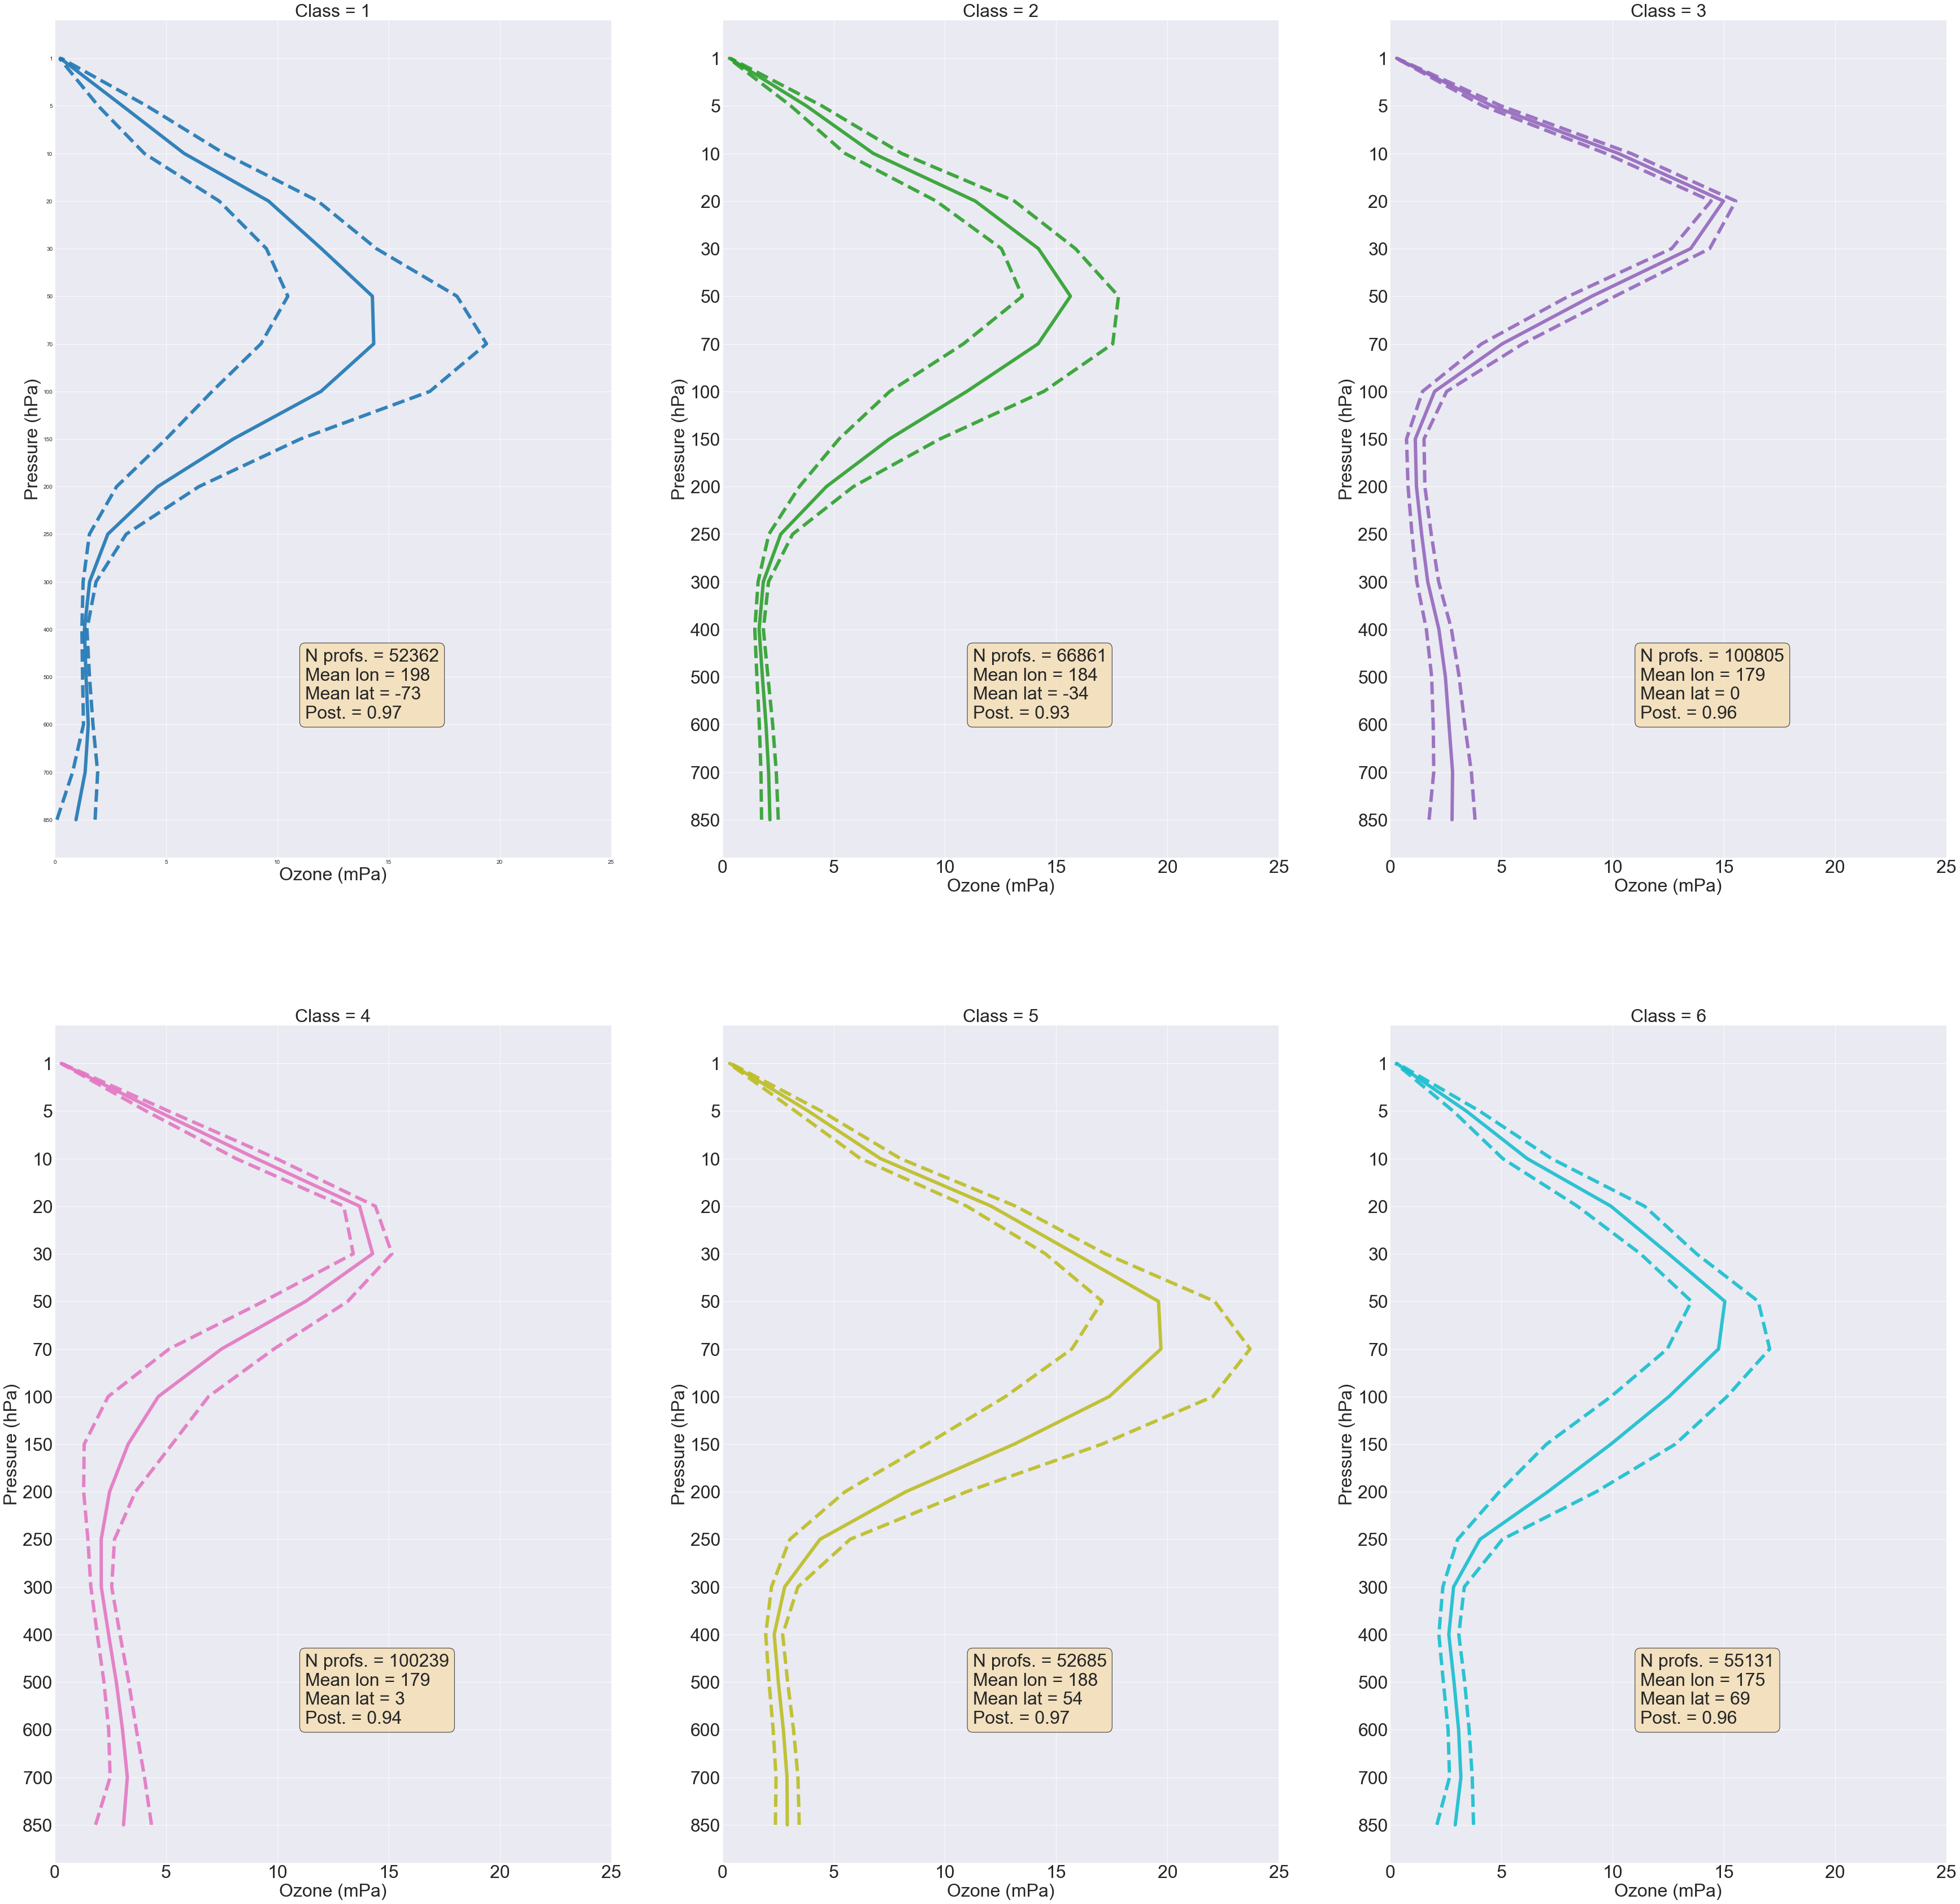

In [22]:
#classes

cNorm = colors.Normalize(vmin=0, vmax=n_comp)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=colormap)

max_ozone_pressure_hist = np.zeros(n_comp)
max_ozone_value_hist = np.zeros(n_comp)
std_ozone_value_hist = np.zeros(n_comp)
 

# initialize the figure
plt.figure(figsize=(60, 60))
plt.style.use('seaborn-darkgrid')
#palette = cmx.Paired(np.linspace(0,1,n_comp))
 
# iterate over groups
num = 0
for nrow in range(0,n_comp):
    num += 1
    colorVal = scalarMap.to_rgba(nrow)
     # extract means
    mean_lon = dfg_means.iloc[nrow,0]
    mean_lat = dfg_means.iloc[nrow,1]
    mean_maxpp = dfg_means.iloc[nrow,3]
    mean_T = dfg_means.iloc[nrow,4:].values
    
    # extract stdevs
    std_lon = dfg_stds.iloc[nrow,0]
    std_lat = dfg_stds.iloc[nrow,1]
    std_maxpp = dfg_stds.iloc[nrow,3]
    std_T = dfg_stds.iloc[nrow,4:].values
    
    # calculate it
    max_ozone_pressure_hist[nrow] = p[np.argmax(mean_T)]
    max_ozone_value_hist[nrow] = np.max(mean_T)
    std_ozone_value_hist[nrow] = np.max(std_T)
    
    print('Class'+str(num))
    print('Maximum at ' + str(max_ozone_pressure_hist[nrow]) + ' hPa')
    print('Maximum ozone value of mean profile = ' + str(max_ozone_value_hist[nrow]))
    print('Standard deviation at level = ' + str(std_ozone_value_hist[nrow]))
    
    # select subplot
    #plt.subplot(np.ceil(n_comp/5),5,num)
    plt.subplot(np.ceil(n_comp/3),3,num)
    plt.plot(mean_T, p, marker='', linestyle='solid', color=colorVal, linewidth=6.0, alpha=0.9)
    plt.plot(mean_T+std_T, p, marker='', linestyle='dashed', color=colorVal, linewidth=6.0, alpha=0.9)
    plt.plot(mean_T-std_T, p, marker='', linestyle='dashed', color=colorVal, linewidth=6.0, alpha=0.9)
    
    # custom grid and axes
    #plt.ylim([0,950])
    ax = plt.gca()
    #ax.invert_yaxis() 
    plt.xlim([0, 25])
    #ax.grid(True)
    
   #text box
    fs = 32 # font size
    plt.xlabel('Ozone (mPa)', fontsize=fs)
    plt.ylabel('Pressure (hPa)', fontsize=fs)
    plt.title('Class = ' + str(num), fontsize=fs)
    mpl.rc('xtick', labelsize=fs)     
    mpl.rc('ytick', labelsize=fs)
    
    # this creates the test boxes that display the class statistics
    textstr = '\n'.join((
        r'N profs. = %i' % (nprofs[nrow], ),
        r'Mean lon = %i' % (mean_lon, ),
        r'Mean lat = %i' % (mean_lat, ),
        r'Post. = %.2f' % (mean_maxpp, )))
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
    # place a text box in upper left in axes coords
    ax.text(0.45, 0.25, textstr, transform=ax.transAxes, fontsize=fs,
            verticalalignment='top', bbox=props)   
   
   #plt.show()

# later, uncomment these to save the figures
#plt.savefig("figures/historicalprofiles.pdf",
            #bbox_inches="tight",transparent=False)

## We will start working with each data set with the same PCA calculated earlier

#### Historical data (2004-2014)

In [23]:
# keep 'data' as the unmodified historical original dataset
data_cleaned1 = data1

# drop rows with NaNs
data_cleaned1 = data_cleaned1.dropna()
data_cleaned1 = data_cleaned1.reset_index(drop=True)

#pressure values from the column headers
p1 = data_cleaned1.columns[3:].values

In [24]:
# let's work with the cleaned up historical datset dataset
df1 = data_cleaned1

# get the latitudes, and longitudes for each profile
lon = df1.iloc[:,0].values
lat = df1.iloc[:,1].values
season = df1.iloc[:,2].values

# get the array that will be used to fit the GMM object
X1 = df1.iloc[:,3:].values

# number of profiles for historical dataset
nProfiles1 = X1[:,1].size

# scale by variable 
Xscaled1 = preprocessing.scale(X1)

# check data frame
df1

,x,y,season,850,700,600,500,400,300,250,200,150,100,70,50,30,20,10,5,1
0,0.9375,-89.375,DJF,0.000000,0.099991,1.317870,1.275637,1.339549,1.838563,2.986827,4.697723,4.587994,5.397292,8.749182,12.559555,12.841137,9.390033,4.856805,2.673725,0.204272
1,0.9375,-89.375,JJA,0.000000,0.039306,1.683980,1.477666,1.281533,1.196284,1.419046,2.541174,5.368797,10.433466,16.512575,15.625815,9.196220,6.558020,2.781719,1.010234,0.169674
2,0.9375,-89.375,MAM,0.000000,0.038577,1.336666,1.227627,1.182483,1.546504,2.580667,4.361568,5.909919,9.756591,14.610302,15.168732,10.096333,6.584430,3.567123,1.779331,0.232079
3,0.9375,-89.375,SON,0.000000,0.074782,1.541470,1.391227,1.271945,1.259319,1.420209,2.324337,4.662927,4.703378,4.604415,5.159846,6.753445,6.899643,4.422953,2.297504,0.221742
4,2.8125,-89.375,DJF,0.000000,0.098728,1.317713,1.275441,1.339394,1.838222,2.986227,4.697357,4.587856,5.396471,8.748376,12.558534,12.841625,9.391102,4.857012,2.673738,0.204271
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107007,357.1875,89.375,MAM,3.230198,3.135224,2.983059,2.779645,2.648739,3.460845,5.815338,10.281789,13.435838,15.727700,16.843928,16.516593,13.484845,10.392876,5.967129,3.104414,0.275747
107008,357.1875,89.375,SON,2.896052,2.879639,2.707690,2.485387,2.330671,2.823322,4.278940,6.844200,8.949165,12.810509,15.039960,14.384839,10.861462,7.990345,4.569005,2.545042,0.284012
107009,359.0625,89.375,DJF,2.664229,2.573197,2.385582,2.171925,2.033299,2.443945,3.661988,6.613581,10.557016,15.837325,18.236601,16.799602,12.196462,9.018058,5.059220,2.522020,0.272950
107010,359.0625,89.375,JJA,3.362948,3.493059,3.362510,3.148649,3.020113,3.715940,5.977703,9.595268,10.131558,12.424713,14.435482,14.213897,10.573501,7.569845,4.970922,2.994963,0.225944


In [25]:
# transform input data into PCA representation
Xpca1 = pca.transform(Xscaled1)

# calculated total variance explained
total_variance_explained_ = np.sum(pca.explained_variance_ratio_) 
print("Total variance explained by principal component representation of dataset")
total_variance_explained_

Total variance explained by principal component representation of dataset


0.9885760933932283

In [26]:
# assign class labels ("predict" the class using the selected GMM)
labels1 = best_gmm.predict(Xpca1)

# find posterior probabilities (the probabilities of belonging to each class)
posterior_probs1 = best_gmm.predict_proba(Xpca1)

# maximum posterior probability (the class is assigned based on this value)
max_posterior_probs1 = np.max(posterior_probs1,axis=1) 

# put the labels and maximum posterior probabilities back in original dataframe
df1.insert(3,'label',labels1,True)
df1.insert(4,'max posterior prob',max_posterior_probs1,True) 

# check data frame
print("Number of classes (before manual grouping)")
df1.label.max()+1

Number of classes (before manual grouping)


6

In [27]:
# group by label
grouped_unsorted1 = df1.groupby('label')

# calculate mean of all profiles in each class
df_means1 = grouped_unsorted1.mean()

oz_means1 = df_means1['y'].values

old2new1 = np.argsort(oz_means1)

# create dictionary object for sorting
di1 = dict(zip(old2new1,range(0,n_components_selected)))

# add new column to dataframe - sorted label
df1.insert(4,'label_sorted',df1['label'].map(di1))

In [28]:
# group profiles according to label
df1_DJF = df1[df1.season=="DJF"]
grouped1_DJF = df1_DJF.groupby('label_sorted')

# calculate mean of all profiles in each class
dfg_means1_DJF = grouped1_DJF.mean()

# calculate stdevs of all profiles in each class
dfg_stds1_DJF = grouped1_DJF.std()

# number or profiles in each class
nprofs1_DJF = grouped1_DJF['x'].count().values

# count number of profiles at each location
gbl1_DJF = df1_DJF.groupby('x')
Al1_DJF=gbl1_DJF.count()['label_sorted']
nprofs1_DJF_ = Al1_DJF[df1_DJF['x'].values].values
#dfg_means1.insert(2,'season',season,True)

#### Plot the means and standard deviations of the classes by profile

In [29]:
# group profiles according to label
df1_MAM = df1[df1.season=="MAM"]
grouped1_MAM = df1_MAM.groupby('label_sorted')

# calculate mean of all profiles in each class
dfg_means1_MAM = grouped1_MAM.mean()

# calculate stdevs of all profiles in each class
dfg_stds1_MAM = grouped1_MAM.std()

# number or profiles in each class
nprofs1_MAM = grouped1_MAM['x'].count().values

# count number of profiles at each location
gbl1_MAM = df1_MAM.groupby('x')
Al1_MAM=gbl1_MAM.count()['label_sorted']
nprofs1_MAM_ = Al1_MAM[df1_MAM['x'].values].values
#dfg_means1.insert(2,'season',season,True)

In [30]:
# group profiles according to label
df1_JJA = df1[df1.season=="JJA"]
grouped1_JJA = df1_JJA.groupby('label_sorted')

# calculate mean of all profiles in each class
dfg_means1_JJA = grouped1_JJA.mean()

# calculate stdevs of all profiles in each class
dfg_stds1_JJA = grouped1_JJA.std()

# number or profiles in each class
nprofs1_JJA = grouped1_JJA['x'].count().values

# count number of profiles at each location
gbl1_JJA = df1_JJA.groupby('x')
Al1_JJA=gbl1_JJA.count()['label_sorted']
nprofs1_JJA_ = Al1_JJA[df1_JJA['x'].values].values
#dfg_means1.insert(2,'season',season,True)

In [31]:
dfg_means1_JJA

,x,y,label,max posterior prob,850,700,600,500,400,300,...,200,150,100,70,50,30,20,10,5,1
label_sorted,,,,,,,,,,,,,,,,,,,,,
0,204.211729,-78.282817,4.0,0.971536,1.025197,1.556150,1.736962,1.533165,1.337216,1.287037,...,2.885451,5.901487,11.608847,16.979683,15.546037,9.593498,6.886127,3.252395,1.418548,0.213471
1,183.316429,-49.272139,0.0,0.966815,2.503190,2.303557,2.099109,1.856787,1.622496,1.646669,...,4.066021,6.953133,10.604189,14.072511,15.806008,14.142847,10.748433,6.172884,3.486714,0.315246
2,182.888894,6.069517,1.0,0.946940,3.146224,3.040326,2.849976,2.687201,2.341761,1.791503,...,1.265645,1.245701,2.435651,5.978689,9.855145,14.152436,15.358461,9.943936,4.316102,0.284954
3,178.975650,14.328747,3.0,0.932861,3.675454,3.749274,3.474322,3.152396,2.756454,2.343132,...,2.527666,3.181829,4.485586,7.290558,11.095378,14.305395,13.952638,8.799288,4.217348,0.275595
5,177.950000,71.396053,2.0,0.970212,3.280918,3.529617,3.434256,3.232471,3.009130,3.311861,...,8.127625,9.243271,11.232034,13.522624,14.017132,11.693489,9.427428,6.166837,3.356917,0.237226


In [32]:
# group profiles according to label
df1_SON = df1[df1.season=="SON"]
grouped1_SON = df1_SON.groupby('label_sorted')

# calculate mean of all profiles in each class
dfg_means1_SON = grouped1_SON.mean()

# calculate stdevs of all profiles in each class
dfg_stds1_SON = grouped1_SON.std()

# number or profiles in each class
nprofs1_SON = grouped1_SON['x'].count().values

# count number of profiles at each location
gbl1_SON = df1_SON.groupby('x')
Al1_SON=gbl1_SON.count()['label_sorted']
nprofs1_SON_ = Al1_SON[df1_SON['x'].values].values
#dfg_means1.insert(2,'season',season,True)

In [33]:
dfg_means1_SON 

,x,y,label,max posterior prob,850,700,600,500,400,300,...,200,150,100,70,50,30,20,10,5,1
label_sorted,,,,,,,,,,,,,,,,,,,,,
0,201.588622,-71.883264,4.0,0.960862,1.306691,1.594054,1.661037,1.521574,1.396463,1.454718,...,3.390851,5.717903,5.873261,6.318962,7.556558,9.645817,9.217944,6.123031,3.143031,0.240050
1,180.856433,-47.744944,0.0,0.918453,2.281434,2.252601,2.150926,1.992167,1.829773,1.998285,...,5.140329,7.343477,9.676694,13.394721,15.999665,15.326139,12.964005,8.111162,4.120590,0.276618
2,180.805606,6.691682,1.0,0.963174,3.233322,3.057555,2.819888,2.601514,2.233150,1.694170,...,1.194694,1.168053,2.275123,5.841141,9.805818,13.973230,15.313029,9.871205,4.168643,0.277889
3,177.574488,-2.690410,3.0,0.942197,3.299078,3.436452,3.181537,2.850974,2.448533,2.075865,...,2.284598,2.780846,4.152202,7.289002,11.318955,14.320668,13.717140,8.897124,4.370919,0.281688
5,180.180056,66.148101,2.0,0.986604,2.971049,3.095350,2.921597,2.656376,2.400039,2.591518,...,5.488640,7.410173,10.695281,13.242119,13.853055,12.270543,9.834917,5.763457,3.180435,0.302688


In the inset text boxes above, "N profs." is the number of profiles in each class. Also shown are class mean values for longitude, latitude, and maximum posterior probability.

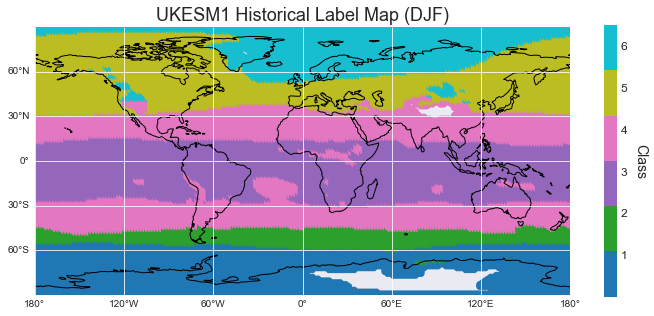

In [34]:
##### DJF 

df1_DJF = df1[df1.season=="DJF"]
df1plot = df1_DJF.groupby(['x','y']).median().reset_index()
plt.figure(figsize=(12, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree())
gl.top_labels = False
gl.right_labels = False
ax.coastlines()
#gl = ax1.gridlines(draw_labels=True, crs=ccrs.PlateCarree())

cplot = df1plot['label_sorted'].values + 1

CS1 = plt.scatter(df1plot['x'].values, df1plot['y'].values, c=cplot,
                 marker='o',cmap= colormap,
                 vmin=0.0, vmax=n_comp+0.5)
                 #transform=ccrs.Geodetic(),
                 
colorbar = plt.colorbar(CS1, shrink=0.5)
cblabels = np.arange(1, int(n_comp)+1, 1)
cbloc = cblabels
colorbar.set_ticks(cbloc)
colorbar.set_ticklabels(cblabels)
colorbar.ax.tick_params(labelsize='large')
colorbar.set_label('Class', rotation=270, labelpad=20,fontsize=14)

plt.title('UKESM1 Historical Label Map (DJF)', fontsize=18) 
#plt.show()


# eventually, uncomment this in order to save the images
#if save_figs==True:
plt.savefig("figures/historical_labels_djf.png",bbox_inches="tight",transparent=False)
    #figfolder = './'
    #plt.savefig(figfolder + "1.labels_historical_djf",bbox_inches="tight",transparent=False)

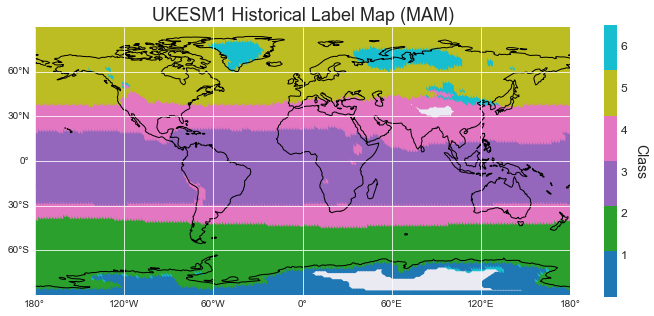

In [35]:
#MAM
n_comp=6
df1_MAM = df1[df1.season=="MAM"]
df1plot = df1_MAM.groupby(['x','y']).median().reset_index()
plt.figure(figsize=(12, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree())
gl.top_labels = False
gl.right_labels = False
ax.coastlines()
#gl = ax1.gridlines(draw_labels=True, crs=ccrs.PlateCarree())

cplot = df1plot['label_sorted'].values + 1

CS1 = plt.scatter(df1plot['x'].values, df1plot['y'].values, c=cplot,
                 marker='o',cmap= colormap,
                 vmin=0.0, vmax=n_comp+0.5)
                 #transform=ccrs.Geodetic(),
                 
colorbar = plt.colorbar(CS1, shrink=0.5)
cblabels = np.arange(1, int(n_comp)+1, 1)
cbloc = cblabels
colorbar.set_ticks(cbloc)
colorbar.set_ticklabels(cblabels)
colorbar.ax.tick_params(labelsize='large')
colorbar.set_label('Class', rotation=270, labelpad=20,fontsize=14)

plt.title('UKESM1 Historical Label Map (MAM)', fontsize=18) 


# eventually, uncomment this in order to save the images
#if save_figs==True:
plt.savefig("figures/historical_labels_MAM.png",bbox_inches="tight",transparent=False)
    #figfolder = './'
    #plt.savefig(figfolder + "1.labels_historical",bbox_inches="tight",transparent=False)
    

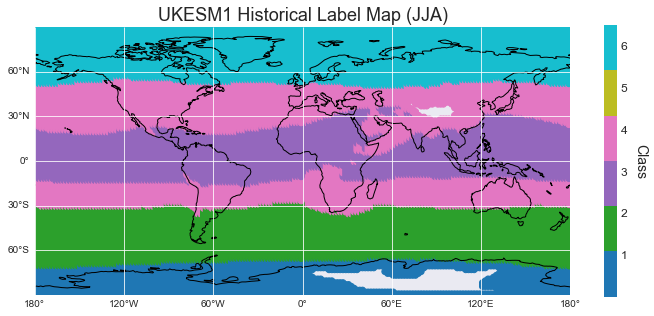

In [36]:
##### JJA
#n_comp=5
df1_JJA = df1[df1.season=="JJA"]
df1plot = df1_JJA.groupby(['x','y']).median().reset_index()
plt.figure(figsize=(12, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree())
gl.top_labels = False
gl.right_labels = False
ax.coastlines()
#gl = ax1.gridlines(draw_labels=True, crs=ccrs.PlateCarree())

cplot = df1plot['label_sorted'].values + 1

CS1 = plt.scatter(df1plot['x'].values, df1plot['y'].values, c=cplot,
                 marker='o',cmap= colormap,
                 vmin=0.0, vmax=n_comp+0.5)
                 #transform=ccrs.Geodetic(),
                 

colorbar = plt.colorbar(CS1, shrink=0.5)
cblabels = np.arange(1, int(n_comp)+1, 1)
cbloc = cblabels
colorbar.set_ticks(cbloc)
colorbar.set_ticklabels(cblabels)
colorbar.ax.tick_params(labelsize='large')
colorbar.set_label('Class', rotation=270, labelpad=20,fontsize=14)

plt.title('UKESM1 Historical Label Map (JJA)', fontsize=18) 
#plt.show()
#if save_figs==True:
plt.savefig("figures/historical_labels_JJA.png",bbox_inches="tight",transparent=False)

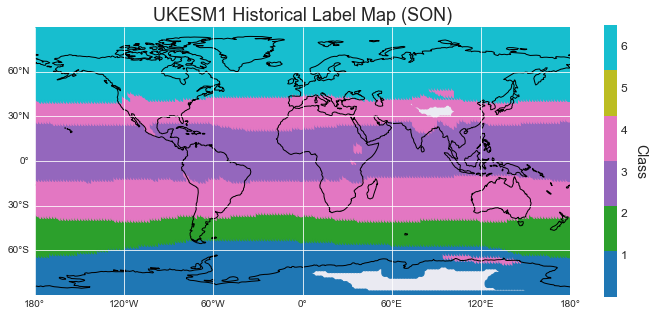

In [37]:
#SON

df1_SON = df1[df1.season=="SON"]
df1plot = df1_SON.groupby(['x','y']).median().reset_index()
plt.figure(figsize=(12, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree())
gl.top_labels = False
gl.right_labels = False
ax.coastlines()
#gl = ax1.gridlines(draw_labels=True, crs=ccrs.PlateCarree())

cplot = df1plot['label_sorted'].values + 1

CS1 = plt.scatter(df1plot['x'].values, df1plot['y'].values, c=cplot,
                 marker='o',cmap= colormap,
                 vmin=0.0, vmax=n_comp+0.5)
                 #transform=ccrs.Geodetic(),
                 
colorbar = plt.colorbar(CS1, shrink=0.5)
cblabels = np.arange(1, int(n_comp)+1, 1)
cbloc = cblabels
colorbar.set_ticks(cbloc)
colorbar.set_ticklabels(cblabels)
colorbar.ax.tick_params(labelsize='large')
colorbar.set_label('Class', rotation=270, labelpad=20,fontsize=14)

plt.title('UKESM1 Historical Label Map (SON)', fontsize=18)
#if save_figs==True:
plt.savefig("figures/historical_labels_SON.png",bbox_inches="tight",transparent=False)

#### PLot the label map for historical data

Text(0.5, 1.0, 'UKESM1 Historical Label Map')

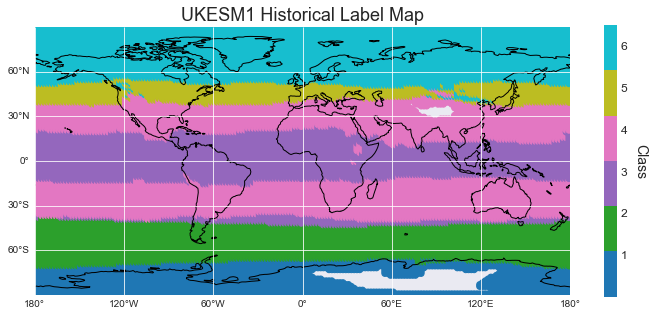

In [38]:
df1plot = df1.groupby(['x','y']).median().reset_index()
plt.figure(figsize=(12, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree())
gl.top_labels = False
gl.right_labels = False
ax.coastlines()
#gl = ax1.gridlines(draw_labels=True, crs=ccrs.PlateCarree())

cplot = df1plot['label_sorted'].values + 1

CS1 = plt.scatter(df1plot['x'].values, df1plot['y'].values, c=cplot,
                 marker='o',cmap= colormap,
                 vmin=0.0, vmax=n_comp+0.5)
                 #transform=ccrs.Geodetic(),
                 

colorbar = plt.colorbar(CS1, shrink=0.5)
cblabels = np.arange(1, int(n_comp)+1, 1)
cbloc = cblabels
colorbar.set_ticks(cbloc)
colorbar.set_ticklabels(cblabels)
colorbar.ax.tick_params(labelsize='large')
colorbar.set_label('Class', rotation=270, labelpad=20,fontsize=14)

plt.title('UKESM1 Historical Label Map', fontsize=18) 
#plt.show()

# eventually, uncomment this in order to save the images
#if save_figs==True:
#plt.savefig("figures/historical_labels",bbox_inches="tight",transparent=False)
#figfolder = './'
#plt.savefig(figfolder + "1.labels_historical",bbox_inches="tight",transparent=False)



## Calculation of the area occupied by each class

In [39]:
x_DJF = df1_DJF['x'].values
y_DJF = df1_DJF['y'].values

x_MAM = df1_MAM['x'].values
y_MAM = df1_MAM['y'].values

x_SON = df1_SON['x'].values
y_SON = df1_SON['y'].values

x_JJA = df1_JJA['x'].values
y_JJA = df1_JJA['y'].values


In [40]:
df1_DJF['cos_lat'] = np.cos(np.radians(df1_DJF['y']))
A1_DJF = df1_DJF.groupby('label_sorted').sum()['cos_lat']

df1_MAM['cos_lat'] = np.cos(np.radians(df1_MAM['y']))
A1_MAM = df1_MAM.groupby('label_sorted').sum()['cos_lat']

df1_JJA['cos_lat'] = np.cos(np.radians(df1_JJA['y']))
A1_JJA = df1_JJA.groupby('label_sorted').sum()['cos_lat']

df1_SON['cos_lat'] = np.cos(np.radians(df1_SON['y']))
A1_SON = df1_SON.groupby('label_sorted').sum()['cos_lat']

C:\Users\fahri\AppData\Local\Temp/ipykernel_18048/4092227236.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1_DJF['cos_lat'] = np.cos(np.radians(df1_DJF['y']))
C:\Users\fahri\AppData\Local\Temp/ipykernel_18048/4092227236.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1_MAM['cos_lat'] = np.cos(np.radians(df1_MAM['y']))
C:\Users\fahri\AppData\Local\Temp/ipykernel_18048/4092227236.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

In [41]:
#area calculation
area_DJF = 100*A1_DJF/np.sum(A1_DJF)
area_DJF

label_sorted
0     7.839549
1     6.176088
2    33.103935
3    31.668467
4    16.820423
5     4.391538
Name: cos_lat, dtype: float64

In [42]:
area_MAM = 100*A1_MAM/np.sum(A1_MAM)
area_MAM

label_sorted
0     1.140064
1    15.573354
2    39.074378
3    26.418392
4    16.375307
5     1.418504
Name: cos_lat, dtype: float64

In [43]:
area_SON = 100*A1_SON/np.sum(A1_SON)
area_SON

label_sorted
0     7.468481
1    11.040118
2    31.082034
3    33.895413
5    16.513954
Name: cos_lat, dtype: float64

In [44]:
area_JJA = 100*A1_JJA/np.sum(A1_JJA)
area_JJA

label_sorted
0     3.124933
1    20.889933
2    29.891223
3    35.812916
5    10.280995
Name: cos_lat, dtype: float64

## We will repeat the process for future projection dataset

#### SSP1-2.6 (Annual mean from 2090-2100 with strong greenhouse emission reduction)

In [45]:
# keep 'data' as the unmodified original dataset
data_cleaned2 = data2 #ssp126

# drop rows with NaNs
data_cleaned2 = data_cleaned2.dropna()
data_cleaned2 = data_cleaned2.reset_index(drop=True)

# for simple plotting, extract an array of values 
A2 = data_cleaned2.drop(columns=['x','y']).values

In [46]:
# let's work with the cleaned up dataset
df2 = data_cleaned2

# get the latitudes, and longitudes for each profile
lon = df2.iloc[:,0].values
lat = df2.iloc[:,1].values
season = df2.iloc[:,2].values

# get the array that will be used to fit the GMM object
X2 = df2.iloc[:,3:].values

# number of profiles
nProfiles2 = X2[:,1].size
nProfiles2
# scale by variable
Xscaled2 = preprocessing.scale(X2)

In [47]:
# transform input data into PCA representation
Xpca2 = pca.transform(Xscaled2)

# calculated total variance explained
total_variance_explained_ = np.sum(pca.explained_variance_ratio_) 
total_variance_explained_

0.9885760933932283

In [48]:
# assign class labels ("predict" the class using the selected GMM)
labels2 = best_gmm.predict(Xpca2)

# find posterior probabilities (the probabilities of belonging to each class)
posterior_probs2 = best_gmm.predict_proba(Xpca2)

# maximum posterior probability (the class is assigned based on this value)
max_posterior_probs2 = np.max(posterior_probs2,axis=1) 

# put the labels and maximum posterior probabilities back in original dataframe
df2.insert(3,'label',labels2,True)
df2.insert(4,'max posterior prob',max_posterior_probs2,True)

In [49]:
# group by label
grouped_unsorted2 = df2.groupby('label')

# calculate mean of all profiles in each class
df_means2 = grouped_unsorted2.mean()

# extrat ozone values 
oz_means2 = df_means2['y'].values

old2new2 = np.argsort(oz_means2)

# create dictionary object for sorting
di2 = dict(zip(old2new2,range(0,n_components_selected )))

# add new column to dataframe - sorted label
df2.insert(4,'label_sorted',df2['label'].map(di2))

In [50]:
# group profiles according to label
df2_DJF = df2[df2.season=="DJF"]
grouped2_DJF = df2_DJF.groupby('label_sorted')

# calculate mean of all profiles in each class
dfg_means2_DJF = grouped2_DJF.mean()

# calculate stdevs of all profiles in each class
dfg_stds2_DJF = grouped2_DJF.std()

# number or profiles in each class
nprofs2_DJF = grouped2_DJF['x'].count().values

# count number of profiles at each location
gbl2_DJF = df2_DJF.groupby('x')
Al2_DJF=gbl2_DJF.count()['label_sorted']
nprofs2_DJF_ = Al2_DJF[df2_DJF['x'].values].values
#dfg_means1.insert(2,'season',season,True)


# group profiles according to label
df2_MAM = df2[df2.season=="MAM"]
grouped2_MAM = df2_MAM.groupby('label_sorted')

# calculate mean of all profiles in each class
dfg_means2_MAM = grouped2_MAM.mean()

# calculate stdevs of all profiles in each class
dfg_stds2_MAM = grouped2_MAM.std()

# number or profiles in each class
nprofs2_MAM = grouped2_MAM['x'].count().values

# count number of profiles at each location
gbl2_MAM = df2_MAM.groupby('x')
Al2_MAM=gbl2_MAM.count()['label_sorted']
nprofs2_MAM_ = Al2_MAM[df2_MAM['x'].values].values
#dfg_means1.insert(2,'season',season,True)

# group profiles according to label
df2_SON = df2[df2.season=="SON"]
grouped2_SON = df2_SON.groupby('label_sorted')

# calculate mean of all profiles in each class
dfg_means2_SON = grouped2_SON.mean()

# calculate stdevs of all profiles in each class
dfg_stds2_SON = grouped2_SON.std()

# number or profiles in each class
nprofs2_SON = grouped2_SON['x'].count().values

# count number of profiles at each location
gbl2_SON = df2_SON.groupby('x')
Al2_SON=gbl2_SON.count()['label_sorted']
nprofs2_SON_ = Al2_SON[df2_SON['x'].values].values
#dfg_means1.insert(2,'season',season,True)

# group profiles according to label
df2_JJA = df2[df2.season=="JJA"]
grouped2_JJA = df2_JJA.groupby('label_sorted')

# calculate mean of all profiles in each class
dfg_means2_JJA = grouped2_JJA.mean()

# calculate stdevs of all profiles in each class
dfg_stds2_JJA = grouped2_JJA.std()

# number or profiles in each class
nprofs2_JJA = grouped2_JJA['x'].count().values

# count number of profiles at each location
gbl2_JJA = df2_JJA.groupby('x')
Al2_JJA=gbl2_JJA.count()['label_sorted']
nprofs2_JJA_ = Al2_JJA[df2_JJA['x'].values].values
#dfg_means1.insert(2,'season',season,True)

#### Plot the means and standard deviations of the classes by profile

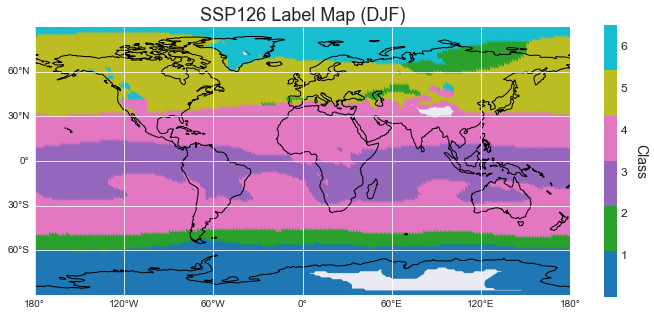

In [51]:
##### DJF 

df2_season = df2[df2.season=="DJF"]
df2plot = df2_season.groupby(['x','y']).median().reset_index()
plt.figure(figsize=(12, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree())
gl.top_labels = False
gl.right_labels = False
ax.coastlines()
#gl = ax1.gridlines(draw_labels=True, crs=ccrs.PlateCarree())

cplot = df2plot['label_sorted'].values + 1

CS1 = plt.scatter(df2plot['x'].values, df2plot['y'].values, c=cplot,
                 marker='o',cmap= colormap,
                 vmin=0.0, vmax=n_comp+0.5)
                 #transform=ccrs.Geodetic(),
                 
colorbar = plt.colorbar(CS1, shrink=0.5)
cblabels = np.arange(1, int(n_comp)+1, 1)
cbloc = cblabels
colorbar.set_ticks(cbloc)
colorbar.set_ticklabels(cblabels)
colorbar.ax.tick_params(labelsize='large')
colorbar.set_label('Class', rotation=270, labelpad=20,fontsize=14)

plt.title('SSP126 Label Map (DJF)', fontsize=18) 
#plt.show()
plt.savefig("figures/SSP126_djf.png",bbox_inches="tight",transparent=False)
##### MAM



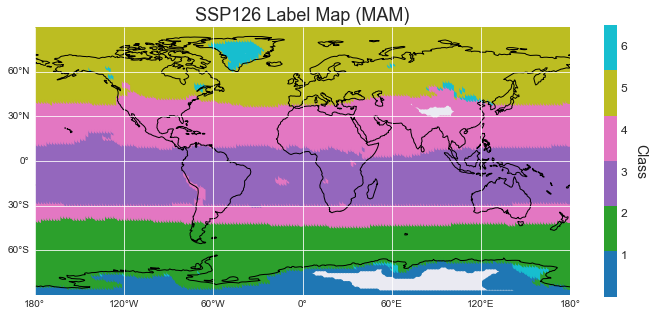

In [52]:
df2_season = df2[df2.season=="MAM"]
df2plot = df2_season.groupby(['x','y']).median().reset_index()
plt.figure(figsize=(12, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree())
gl.top_labels = False
gl.right_labels = False
ax.coastlines()
#gl = ax1.gridlines(draw_labels=True, crs=ccrs.PlateCarree())

cplot = df2plot['label_sorted'].values + 1

CS1 = plt.scatter(df2plot['x'].values, df2plot['y'].values, c=cplot,
                 marker='o',cmap= colormap,
                 vmin=0.0, vmax=n_comp+0.5)
                 #transform=ccrs.Geodetic(),
                 
colorbar = plt.colorbar(CS1, shrink=0.5)
cblabels = np.arange(1, int(n_comp)+1, 1)
cbloc = cblabels
colorbar.set_ticks(cbloc)
colorbar.set_ticklabels(cblabels)
colorbar.ax.tick_params(labelsize='large')
colorbar.set_label('Class', rotation=270, labelpad=20,fontsize=14)

plt.title('SSP126 Label Map (MAM)', fontsize=18)
plt.savefig("figures/SSP126_mam.png",bbox_inches="tight",transparent=False)


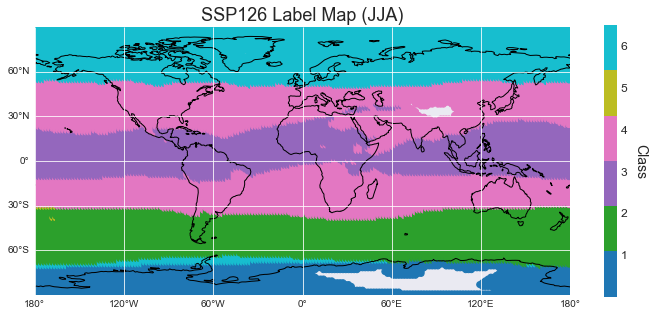

In [53]:
##### JJA

df2_season = df2[df2.season=="JJA"]
df2plot = df2_season.groupby(['x','y']).median().reset_index()
plt.figure(figsize=(12, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree())
gl.top_labels = False
gl.right_labels = False
ax.coastlines()
#gl = ax1.gridlines(draw_labels=True, crs=ccrs.PlateCarree())

cplot = df2plot['label_sorted'].values + 1

CS1 = plt.scatter(df2plot['x'].values, df2plot['y'].values, c=cplot,
                 marker='o',cmap= colormap,
                 vmin=0.0, vmax=n_comp+0.5)
                 #transform=ccrs.Geodetic(),
                 
colorbar = plt.colorbar(CS1, shrink=0.5)
cblabels = np.arange(1, int(n_comp)+1, 1)
cbloc = cblabels
colorbar.set_ticks(cbloc)
colorbar.set_ticklabels(cblabels)
colorbar.ax.tick_params(labelsize='large')
colorbar.set_label('Class', rotation=270, labelpad=20,fontsize=14)

plt.title('SSP126 Label Map (JJA)', fontsize=18) 
plt.savefig("figures/SSP126_jja.png",bbox_inches="tight",transparent=False)


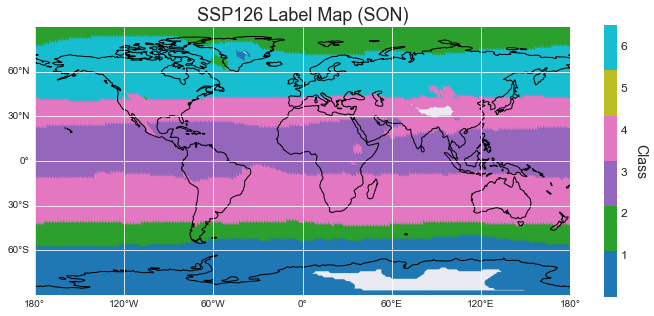

In [54]:
##### SON

df2_season = df2[df2.season=="SON"]
df2plot = df2_season.groupby(['x','y']).median().reset_index()
plt.figure(figsize=(12, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree())
gl.top_labels = False
gl.right_labels = False
ax.coastlines()
#gl = ax1.gridlines(draw_labels=True, crs=ccrs.PlateCarree())

cplot = df2plot['label_sorted'].values + 1

CS1 = plt.scatter(df2plot['x'].values, df2plot['y'].values, c=cplot,
                 marker='o',cmap= colormap,
                 vmin=0.0, vmax=n_comp+0.5)
                 #transform=ccrs.Geodetic(),
                 
colorbar = plt.colorbar(CS1, shrink=0.5)
cblabels = np.arange(1, int(n_comp)+1, 1)
cbloc = cblabels
colorbar.set_ticks(cbloc)
colorbar.set_ticklabels(cblabels)
colorbar.ax.tick_params(labelsize='large')
colorbar.set_label('Class', rotation=270, labelpad=20,fontsize=14)

plt.title('SSP126 Label Map (SON)', fontsize=18) 
plt.savefig("figures/SSP126_son.png",bbox_inches="tight",transparent=False)

In the inset text boxes above, "N profs." is the number of profiles in each class. Also shown are class mean values for longitude, latitude, and maximum posterior probability.

#### Plot the label map

#### Area calculation

In [55]:
df2['cos_lat'] = np.cos(np.radians(df2['y']))
A2 = df2.groupby('label_sorted').sum()['cos_lat']
area_ssp126 = 100*A2/np.sum(A2)
area_ssp126

label_sorted
0     5.349368
1    12.168625
2    27.736691
3    39.302757
4     8.476681
5     6.965878
Name: cos_lat, dtype: float64

In [56]:
x_DJF = df2_DJF['x'].values
y_DJF = df2_DJF['y'].values

x_MAM = df2_MAM['x'].values
y_MAM = df2_MAM['y'].values

x_SON = df2_SON['x'].values
y_SON = df2_SON['y'].values

x_JJA = df2_JJA['x'].values
y_JJA = df2_JJA['y'].values


df2_DJF['cos_lat'] = np.cos(np.radians(df2_DJF['y']))
A2_DJF = df2_DJF.groupby('label_sorted').sum()['cos_lat']

df2_MAM['cos_lat'] = np.cos(np.radians(df2_MAM['y']))
A2_MAM = df2_MAM.groupby('label_sorted').sum()['cos_lat']

df2_JJA['cos_lat'] = np.cos(np.radians(df2_JJA['y']))
A2_JJA = df2_JJA.groupby('label_sorted').sum()['cos_lat']

df2_SON['cos_lat'] = np.cos(np.radians(df2_SON['y']))
A2_SON = df2_SON.groupby('label_sorted').sum()['cos_lat']

C:\Users\fahri\AppData\Local\Temp/ipykernel_18048/2525192065.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_DJF['cos_lat'] = np.cos(np.radians(df2_DJF['y']))
C:\Users\fahri\AppData\Local\Temp/ipykernel_18048/2525192065.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_MAM['cos_lat'] = np.cos(np.radians(df2_MAM['y']))
C:\Users\fahri\AppData\Local\Temp/ipykernel_18048/2525192065.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

In [57]:
#area calculation
area126_DJF = 100*A2_DJF/np.sum(A2_DJF)
area126_DJF

label_sorted
0     7.875928
1     6.208887
2    24.547147
3    42.378296
4    17.061463
5     1.928279
Name: cos_lat, dtype: float64

In [58]:
area126_SON = 100*A2_SON/np.sum(A2_SON)
area126_SON

label_sorted
0     9.601361
1     8.601659
2    28.190758
3    39.374677
5    14.231544
Name: cos_lat, dtype: float64

In [59]:
area126_MAM = 100*A2_MAM/np.sum(A2_MAM)
area126_MAM

label_sorted
0     1.072098
1    15.479270
2    32.512432
3    33.509192
4    16.800063
5     0.626946
Name: cos_lat, dtype: float64

In [60]:
area126_JJA = 100*A2_JJA/np.sum(A2_JJA)
area126_JJA

label_sorted
0     2.850883
1    18.379645
2    25.696583
3    41.948562
4     0.048670
5    11.075656
Name: cos_lat, dtype: float64

#### SSP5-8.5 (Annual mean from 2090-2100 with no greenhouse emission reduction)

In [61]:
# keep 'data' as the unmodified original dataset
data_cleaned3 = data3 #ssp585

# drop rows with NaNs
data_cleaned3 = data_cleaned3.dropna()
data_cleaned3 = data_cleaned3.reset_index(drop=True)

# let's work with the cleaned up dataset
df3 = data_cleaned3

# get the latitudes, and longitudes for each profile
lon = df3.iloc[:,0].values
lat = df3.iloc[:,1].values
season = df3.iloc[:,2].values

# get the array that will be used to fit the GMM object
X3 = df3.iloc[:,3:].values

# number of profiles
nProfiles3 = X3[:,1].size
nProfiles3
# scale by variable
Xscaled3 = preprocessing.scale(X3)

In [62]:
# transform input data into PCA representation
Xpca3 = pca.transform(Xscaled3)

# calculated total variance explained
total_variance_explained_ = np.sum(pca.explained_variance_ratio_) 
total_variance_explained_

# select colormap
#colormap = plt.get_cmap('rainbow', n_comp)

# assign class labels ("predict" the class using the selected GMM)
labels3 = best_gmm.predict(Xpca3)

# find posterior probabilities (the probabilities of belonging to each class)
posterior_probs3 = best_gmm.predict_proba(Xpca3)

# maximum posterior probability (the class is assigned based on this value)
max_posterior_probs3 = np.max(posterior_probs3,axis=1) 

# put the labels and maximum posterior probabilities back in original dataframe
df3.insert(3,'label',labels3,True)
df3.insert(4,'max posterior prob',max_posterior_probs3,True)

In [63]:
# group by label
grouped_unsorted3 = df3.groupby('label')

# calculate mean of all profiles in each class
df_means3 = grouped_unsorted3.mean()

oz_means3 = df_means3['y'].values

old2new3 = np.argsort(oz_means3)

# create dictionary object for sorting
di3 = dict(zip(old2new3,range(0,n_components_selected)))

# add new column to dataframe - sorted label
df3.insert(4,'label_sorted',df3['label'].map(di3))


In [64]:
# group profiles according to label
df3_DJF = df3[df3.season=="DJF"]
grouped3_DJF = df3_DJF.groupby('label_sorted')

# calculate mean of all profiles in each class
dfg_means3_DJF = grouped3_DJF.mean()

# calculate stdevs of all profiles in each class
dfg_stds3_DJF = grouped3_DJF.std()

# number or profiles in each class
nprofs3_DJF = grouped3_DJF['x'].count().values

# count number of profiles at each location
gbl3_DJF = df3_DJF.groupby('x')
Al3_DJF=gbl3_DJF.count()['label_sorted']
nprofs3_DJF_ = Al3_DJF[df3_DJF['x'].values].values
#dfg_means1.insert(2,'season',season,True)


# group profiles according to label
df3_MAM = df3[df3.season=="MAM"]
grouped3_MAM = df3_MAM.groupby('label_sorted')

# calculate mean of all profiles in each class
dfg_means3_MAM = grouped3_MAM.mean()

# calculate stdevs of all profiles in each class
dfg_stds3_MAM = grouped3_MAM.std()

# number or profiles in each class
nprofs3_MAM = grouped3_MAM['x'].count().values

# count number of profiles at each location
gbl3_MAM = df3_MAM.groupby('x')
Al3_MAM=gbl3_MAM.count()['label_sorted']
nprofs3_MAM_ = Al3_MAM[df3_MAM['x'].values].values
#dfg_means1.insert(2,'season',season,True)

# group profiles according to label
df3_SON = df3[df3.season=="SON"]
grouped3_SON = df3_SON.groupby('label_sorted')

# calculate mean of all profiles in each class
dfg_means3_SON = grouped3_SON.mean()

# calculate stdevs of all profiles in each class
dfg_stds3_SON = grouped3_SON.std()

# number or profiles in each class
nprofs3_SON = grouped3_SON['x'].count().values

# count number of profiles at each location
gbl3_SON = df3_SON.groupby('x')
Al3_SON=gbl3_SON.count()['label_sorted']
nprofs3_SON_ = Al3_SON[df3_SON['x'].values].values
#dfg_means1.insert(2,'season',season,True)

# group profiles according to label
df3_JJA = df3[df3.season=="JJA"]
grouped3_JJA = df3_JJA.groupby('label_sorted')

# calculate mean of all profiles in each class
dfg_means3_JJA = grouped3_JJA.mean()

# calculate stdevs of all profiles in each class
dfg_stds3_JJA = grouped3_JJA.std()

# number or profiles in each class
nprofs3_JJA = grouped3_JJA['x'].count().values

# count number of profiles at each location
gbl3_JJA = df3_JJA.groupby('x')
Al3_JJA=gbl3_JJA.count()['label_sorted']
nprofs3_JJA_ = Al3_JJA[df3_JJA['x'].values].values
#dfg_means1.insert(2,'season',season,True)

In [65]:
x_DJF = df3_DJF['x'].values
y_DJF = df3_DJF['y'].values

x_MAM = df3_MAM['x'].values
y_MAM = df3_MAM['y'].values

x_SON = df3_SON['x'].values
y_SON = df3_SON['y'].values

x_JJA = df3_JJA['x'].values
y_JJA = df3_JJA['y'].values


df3_DJF['cos_lat'] = np.cos(np.radians(df3_DJF['y']))
A3_DJF = df3_DJF.groupby('label_sorted').sum()['cos_lat']

df3_MAM['cos_lat'] = np.cos(np.radians(df3_MAM['y']))
A3_MAM = df3_MAM.groupby('label_sorted').sum()['cos_lat']

df3_JJA['cos_lat'] = np.cos(np.radians(df3_JJA['y']))
A3_JJA = df3_JJA.groupby('label_sorted').sum()['cos_lat']

df3_SON['cos_lat'] = np.cos(np.radians(df3_SON['y']))
A3_SON = df3_SON.groupby('label_sorted').sum()['cos_lat']

C:\Users\fahri\AppData\Local\Temp/ipykernel_18048/708482298.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3_DJF['cos_lat'] = np.cos(np.radians(df3_DJF['y']))
C:\Users\fahri\AppData\Local\Temp/ipykernel_18048/708482298.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3_MAM['cos_lat'] = np.cos(np.radians(df3_MAM['y']))
C:\Users\fahri\AppData\Local\Temp/ipykernel_18048/708482298.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

In [66]:
area585_DJF = 100*A3_DJF/np.sum(A3_DJF)
area585_DJF

label_sorted
0     9.524727
1     3.906822
2    25.550640
3    40.711255
4    19.919313
5     0.387243
Name: cos_lat, dtype: float64

In [67]:
area585_MAM = 100*A3_MAM/np.sum(A3_MAM)
area585_MAM

label_sorted
0     1.264016
1    14.837547
2    39.589680
3    27.116153
4    16.163569
5     1.029035
Name: cos_lat, dtype: float64

In [68]:
area585_SON = 100*A3_SON/np.sum(A3_SON)
area585_SON

label_sorted
0    11.949731
1     9.742785
2    31.909164
3    30.675425
5    15.722895
Name: cos_lat, dtype: float64

In [69]:
area585_JJA = 100*A3_JJA/np.sum(A3_JJA)
area585_JJA

label_sorted
0     2.814701
1    11.944915
2    28.112556
3    37.525747
4     8.089629
5    11.512452
Name: cos_lat, dtype: float64

In the inset text boxes above, "N profs." is the number of profiles in each class. Also shown are class mean values for longitude, latitude, and maximum posterior probability.

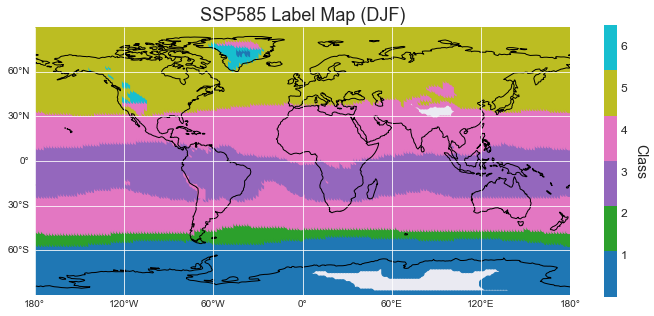

In [70]:
##### DJF 

df3_season = df3[df3.season=="DJF"]
df3plot = df3_season.groupby(['x','y']).median().reset_index()
plt.figure(figsize=(12, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree())
gl.top_labels = False
gl.right_labels = False
ax.coastlines()
#gl = ax1.gridlines(draw_labels=True, crs=ccrs.PlateCarree())

cplot = df3plot['label_sorted'].values + 1

CS3 = plt.scatter(df3plot['x'].values, df3plot['y'].values, c=cplot,
                 marker='o',cmap= colormap,
                 vmin=0.0, vmax=n_comp+0.5)
                 #transform=ccrs.Geodetic(),
                 
colorbar = plt.colorbar(CS3, shrink=0.5)
cblabels = np.arange(1, int(n_comp)+1, 1)
cbloc = cblabels
colorbar.set_ticks(cbloc)
colorbar.set_ticklabels(cblabels)
colorbar.ax.tick_params(labelsize='large')
colorbar.set_label('Class', rotation=270, labelpad=20,fontsize=14)

plt.title('SSP585 Label Map (DJF)', fontsize=18) 
plt.savefig("figures/SSP585_djf.png",bbox_inches="tight",transparent=False)



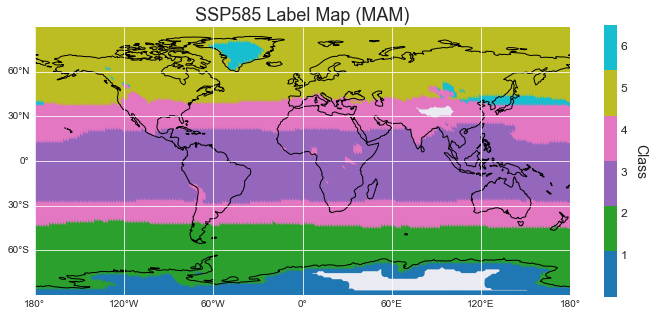

In [71]:
##### MAM 

df3_season = df3[df3.season=="MAM"]
df3plot = df3_season.groupby(['x','y']).median().reset_index()
plt.figure(figsize=(12, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree())
gl.top_labels = False
gl.right_labels = False
ax.coastlines()
#gl = ax1.gridlines(draw_labels=True, crs=ccrs.PlateCarree())

cplot = df3plot['label_sorted'].values + 1

CS3 = plt.scatter(df3plot['x'].values, df3plot['y'].values, c=cplot,
                 marker='o',cmap= colormap,
                 vmin=0.0, vmax=n_comp+0.5)
                 #transform=ccrs.Geodetic(),
                 
colorbar = plt.colorbar(CS3, shrink=0.5)
cblabels = np.arange(1, int(n_comp)+1, 1)
cbloc = cblabels
colorbar.set_ticks(cbloc)
colorbar.set_ticklabels(cblabels)
colorbar.ax.tick_params(labelsize='large')
colorbar.set_label('Class', rotation=270, labelpad=20,fontsize=14)

plt.title('SSP585 Label Map (MAM)', fontsize=18)
plt.savefig("figures/SSP585_mam.png",bbox_inches="tight",transparent=False)



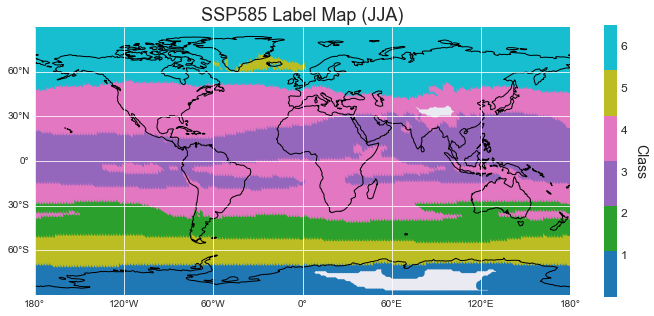

In [72]:
##### JJA

df3_season = df3[df3.season=="JJA"]
df3plot = df3_season.groupby(['x','y']).median().reset_index()
plt.figure(figsize=(12, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree())
gl.top_labels = False
gl.right_labels = False
ax.coastlines()
#gl = ax1.gridlines(draw_labels=True, crs=ccrs.PlateCarree())

cplot = df3plot['label_sorted'].values + 1

CS3 = plt.scatter(df3plot['x'].values, df3plot['y'].values, c=cplot,
                 marker='o',cmap= colormap,
                 vmin=0.0, vmax=n_comp+0.5)
                 #transform=ccrs.Geodetic(),
                 
colorbar = plt.colorbar(CS3, shrink=0.5)
cblabels = np.arange(1, int(n_comp)+1, 1)
cbloc = cblabels
colorbar.set_ticks(cbloc)
colorbar.set_ticklabels(cblabels)
colorbar.ax.tick_params(labelsize='large')
colorbar.set_label('Class', rotation=270, labelpad=20,fontsize=14)

plt.title('SSP585 Label Map (JJA)', fontsize=18)
plt.savefig("figures/SSP585_jja.png",bbox_inches="tight",transparent=False)



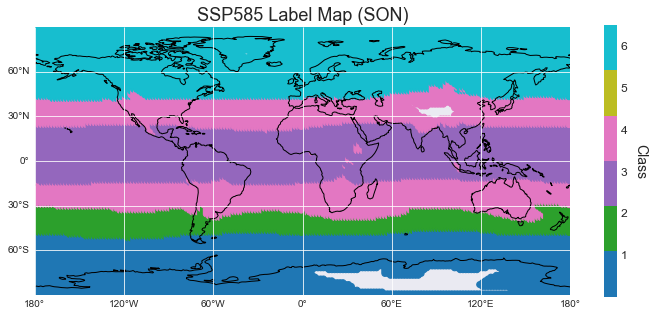

In [73]:
##### SON

df3_season = df3[df3.season=="SON"]
df3plot = df3_season.groupby(['x','y']).median().reset_index()
plt.figure(figsize=(12, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree())
gl.top_labels = False
gl.right_labels = False
ax.coastlines()
#gl = ax1.gridlines(draw_labels=True, crs=ccrs.PlateCarree())

cplot = df3plot['label_sorted'].values + 1

CS3 = plt.scatter(df3plot['x'].values, df3plot['y'].values, c=cplot,
                 marker='o',cmap= colormap,
                 vmin=0.0, vmax=n_comp+0.5)
                 #transform=ccrs.Geodetic(),
                 
colorbar = plt.colorbar(CS3, shrink=0.5)
cblabels = np.arange(1, int(n_comp)+1, 1)
cbloc = cblabels
colorbar.set_ticks(cbloc)
colorbar.set_ticklabels(cblabels)
colorbar.ax.tick_params(labelsize='large')
colorbar.set_label('Class', rotation=270, labelpad=20,fontsize=14)

plt.title('SSP585 Label Map (SON)', fontsize=18)
plt.savefig("figures/SSP585_son.png",bbox_inches="tight",transparent=False)

## Next section is to generate table in latex script directly from here

#### Ozone concentartion at selected pressure level (850 hPa)

In [74]:
#generate table
# historical
surface_means_hist = df1[['label_sorted','850']].groupby('label_sorted').mean()
surface_stds_hist  = df1[['label_sorted','850']].groupby('label_sorted').std()

# SSP126
surface_means_ssp126 = df2[['label_sorted','850']].groupby('label_sorted').mean()
surface_stds_ssp126  = df2[['label_sorted','850']].groupby('label_sorted').std()

# SSP585
surface_means_ssp585 = df3[['label_sorted','850']].groupby('label_sorted').mean()
surface_stds_ssp585  = df3[['label_sorted','850']].groupby('label_sorted').std()

# establish table 
header = ['Class','Hist (mean)','(std)','SSP126 (mean)','(std)','SSP585 (mean)','(std)']
A = pd.concat([pd.Series((1,2,3,4,5,6)),
               surface_means_hist,
               surface_stds_hist,
               surface_means_ssp126,
               surface_stds_ssp126,
               surface_means_ssp585,
               surface_stds_ssp585],axis=1).round(2)
rows = A.values.tolist()
rows.append(header)
surface_table = rows[-1:]+rows[:-1]
surface_table

# create table object
table = Texttable()
#table.set_cols_align(["c"] * 7)
table.set_deco(Texttable.HEADER | Texttable.VLINES)
table.add_rows(surface_table)

print('\nTexttable Table:')
print(table.draw())

print('\nTexttable Latex:')
print(latextable.draw_latex(table, caption="Ozone concentration statistics at 850 hPa for the historical, SSP126, and SSP585 experiments, shown in mPa"))


Texttable Table:
Class | Hist (mean) | (std) | SSP126 (mean) | (std) | SSP585 (mean) | (std)
======+=============+=======+===============+=======+===============+======
1     | 0.990       | 0.890 | 0.900         | 0.790 | 1.040         | 0.880
2     | 2.150       | 0.380 | 1.980         | 0.330 | 2.160         | 0.450
3     | 2.990       | 0.950 | 2.210         | 0.700 | 2.560         | 1.080
4     | 3.360       | 1.290 | 2.620         | 0.920 | 3.190         | 1.330
5     | 3.190       | 0.440 | 2.310         | 0.260 | 3             | 0.440
6     | 2.940       | 0.780 | 2.250         | 0.610 | 3.290         | 0.850

Texttable Latex:
\begin{table}
	\begin{center}
		\begin{tabular}{l|l|l|l|l|l|l}
			Class & Hist (mean) & (std) & SSP126 (mean) & (std) & SSP585 (mean) & (std) \\
			\hline
			1 & 0.990 & 0.890 & 0.900 & 0.790 & 1.040 & 0.880 \\
			2 & 2.150 & 0.380 & 1.980 & 0.330 & 2.160 & 0.450 \\
			3 & 2.990 & 0.950 & 2.210 & 0.700 & 2.560 & 1.080 \\
			4 & 3.360 & 1.290 & 2.620 & 0.

In [79]:
from tabulate import tabulate
from texttable import Texttable

import latextable

# create list of lists for table
header = ['Class', 'Historical(DJF)', 'SSP126(DJF)', 'SSP585(DJF)']
all_areas_DJF = pd.concat([pd.Series((1,2,3,4,5,6)),area_DJF, area126_DJF, area585_DJF], axis=1).round(1)
rows = all_areas_DJF.values.tolist()
rows.append(header)
area_table = rows[-1:]+rows[:-1]

# create table object
table = Texttable()
table.set_cols_align(["c"] * 4)
table.set_deco(Texttable.HEADER | Texttable.VLINES)
table.add_rows(area_table)

print('\nTexttable Table:')
print(table.draw())

print('\nTexttable Latex:')
print(latextable.draw_latex(table, caption="Relative area occupied by each class (DJF), shown in percentages."))


Texttable Table:
Class | Historical(DJF) | SSP126(DJF) | SSP585(DJF)
======+=================+=============+============
  1   |      7.800      |    7.900    |    9.500   
  2   |      6.200      |    6.200    |    3.900   
  3   |     33.100      |   24.500    |   25.600   
  4   |     31.700      |   42.400    |   40.700   
  5   |     16.800      |   17.100    |   19.900   
  6   |      4.400      |    1.900    |    0.400   

Texttable Latex:
\begin{table}
	\begin{center}
		\begin{tabular}{c|c|c|c}
			Class & Historical(DJF) & SSP126(DJF) & SSP585(DJF) \\
			\hline
			1 & 7.800 & 7.900 & 9.500 \\
			2 & 6.200 & 6.200 & 3.900 \\
			3 & 33.100 & 24.500 & 25.600 \\
			4 & 31.700 & 42.400 & 40.700 \\
			5 & 16.800 & 17.100 & 19.900 \\
			6 & 4.400 & 1.900 & 0.400 \\
		\end{tabular}
	\end{center}
	\caption{Relative area occupied by each class (DJF), shown in percentages.}
\end{table}


In [84]:
from tabulate import tabulate
from texttable import Texttable

import latextable

# create list of lists for table
header = ['Class', 'Historical(JJA)', 'SSP126(JJA)', 'SSP585(JJA)']
all_areas_JJA = pd.concat([pd.Series((1,2,3,4,5,6)),area_JJA, area126_JJA, area585_JJA], axis=1).round(1)
rows = all_areas_JJA.values.tolist()
rows.append(header)
area_table = rows[-1:]+rows[:-1]

# create table object
table = Texttable()
table.set_cols_align(["c"] * 4)
table.set_deco(Texttable.HEADER | Texttable.VLINES)
table.add_rows(area_table)

print('\nTexttable Table:')
print(table.draw())

print('\nTexttable Latex:')
print(latextable.draw_latex(table, caption="Relative area occupied by each class (JJA), shown in percentages."))


Texttable Table:
Class | Historical(JJA) | SSP126(JJA) | SSP585(JJA)
======+=================+=============+============
  1   |      3.100      |    2.900    |    2.800   
  2   |     20.900      |   18.400    |   11.900   
  3   |     29.900      |   25.700    |   28.100   
  4   |     35.800      |   41.900    |   37.500   
  5   |       nan       |      0      |    8.100   
  6   |     10.300      |   11.100    |   11.500   

Texttable Latex:
\begin{table}
	\begin{center}
		\begin{tabular}{c|c|c|c}
			Class & Historical(JJA) & SSP126(JJA) & SSP585(JJA) \\
			\hline
			1 & 3.100 & 2.900 & 2.800 \\
			2 & 20.900 & 18.400 & 11.900 \\
			3 & 29.900 & 25.700 & 28.100 \\
			4 & 35.800 & 41.900 & 37.500 \\
			5 & nan & 0 & 8.100 \\
			6 & 10.300 & 11.100 & 11.500 \\
		\end{tabular}
	\end{center}
	\caption{Relative area occupied by each class (JJA), shown in percentages.}
\end{table}


In [85]:
from tabulate import tabulate
from texttable import Texttable

import latextable

# create list of lists for table
header = ['Class', 'Historical(SON)', 'SSP126(SON)', 'SSP585(SON)']
all_areas_SON = pd.concat([pd.Series((1,2,3,4,5,6)),area_SON, area126_SON, area585_SON], axis=1).round(1)
rows = all_areas_SON.values.tolist()
rows.append(header)
area_table = rows[-1:]+rows[:-1]

# create table object
table = Texttable()
table.set_cols_align(["c"] * 4)
table.set_deco(Texttable.HEADER | Texttable.VLINES)
table.add_rows(area_table)

print('\nTexttable Table:')
print(table.draw())

print('\nTexttable Latex:')
print(latextable.draw_latex(table, caption="Relative area occupied by each class (SON), shown in percentages."))


Texttable Table:
Class | Historical(SON) | SSP126(SON) | SSP585(SON)
======+=================+=============+============
  1   |      7.500      |    9.600    |   11.900   
  2   |       11        |    8.600    |    9.700   
  3   |     31.100      |   28.200    |   31.900   
  4   |     33.900      |   39.400    |   30.700   
  5   |       nan       |     nan     |     nan    
  6   |     16.500      |   14.200    |   15.700   

Texttable Latex:
\begin{table}
	\begin{center}
		\begin{tabular}{c|c|c|c}
			Class & Historical(SON) & SSP126(SON) & SSP585(SON) \\
			\hline
			1 & 7.500 & 9.600 & 11.900 \\
			2 & 11 & 8.600 & 9.700 \\
			3 & 31.100 & 28.200 & 31.900 \\
			4 & 33.900 & 39.400 & 30.700 \\
			5 & nan & nan & nan \\
			6 & 16.500 & 14.200 & 15.700 \\
		\end{tabular}
	\end{center}
	\caption{Relative area occupied by each class (SON), shown in percentages.}
\end{table}


In [86]:
# create list of lists for table
header = ['Class', 'Historical(MAM)', 'SSP126(MAM)', 'SSP585(MAM)']
all_areas_MAM = pd.concat([pd.Series((1,2,3,4,5,6)),area_MAM, area126_MAM, area585_MAM], axis=1).round(1)
rows = all_areas_MAM.values.tolist()
rows.append(header)
area_table = rows[-1:]+rows[:-1]

# create table object
table = Texttable()
table.set_cols_align(["c"] * 4)
table.set_deco(Texttable.HEADER | Texttable.VLINES)
table.add_rows(area_table)

print('\nTexttable Table:')
print(table.draw())

print('\nTexttable Latex:')
print(latextable.draw_latex(table, caption="Relative area occupied by each class (MAM), shown in percentages."))


Texttable Table:
Class | Historical(MAM) | SSP126(MAM) | SSP585(MAM)
======+=================+=============+============
  1   |      1.100      |    1.100    |    1.300   
  2   |     15.600      |   15.500    |   14.800   
  3   |     39.100      |   32.500    |   39.600   
  4   |     26.400      |   33.500    |   27.100   
  5   |     16.400      |   16.800    |   16.200   
  6   |      1.400      |    0.600    |      1     

Texttable Latex:
\begin{table}
	\begin{center}
		\begin{tabular}{c|c|c|c}
			Class & Historical(MAM) & SSP126(MAM) & SSP585(MAM) \\
			\hline
			1 & 1.100 & 1.100 & 1.300 \\
			2 & 15.600 & 15.500 & 14.800 \\
			3 & 39.100 & 32.500 & 39.600 \\
			4 & 26.400 & 33.500 & 27.100 \\
			5 & 16.400 & 16.800 & 16.200 \\
			6 & 1.400 & 0.600 & 1 \\
		\end{tabular}
	\end{center}
	\caption{Relative area occupied by each class (MAM), shown in percentages.}
\end{table}


In [87]:
names = pd.Series(('Southern Hemispheric (Classes 1+2)',
                                        'Tropical (Classes 3+4)',
                                        'Northern Hemispheric (Classes 5+6)'))

m1 = pd.Series(all_areas_DJF.iloc[0:2,1:].sum().values.round(1).tolist())  # returns the row for 1+2 (southern hemisphere)
m2 = pd.Series(all_areas_DJF.iloc[2:4,1:].sum().values.round(1).tolist())  # returns the row for 3+4 (tropics)
m3 = pd.Series(all_areas_DJF.iloc[4:6,1:].sum().values.round(1).tolist())  # returns the row for 5+6 (northern hemisphere)
areas_by_region = pd.concat([m1,m2,m3], axis=1).round(1).T

header = ['Historical(DJF)', 'SSP126(DJF)', 'SSP585(DJF)']
rows = areas_by_region.values.tolist()
rows.append(header)
area_region_table_DJF = rows[-1:]+rows[:-1]

In [89]:
names = pd.Series(('Southern Hemispheric (Classes 1+2)',
                                        'Tropical (Classes 3+4)',
                                        'Northern Hemispheric (Classes 5+6)'))

m1 = pd.Series(all_areas_MAM.iloc[0:2,1:].sum().values.round(1).tolist())  # returns the row for 1+2 (southern hemisphere)
m2 = pd.Series(all_areas_MAM.iloc[2:4,1:].sum().values.round(1).tolist())  # returns the row for 3+4 (tropics)
m3 = pd.Series(all_areas_MAM.iloc[4:6,1:].sum().values.round(1).tolist())  # returns the row for 5+6 (northern hemisphere)
areas_by_region = pd.concat([m1,m2,m3], axis=1).round(1).T

header = ['Historical(MAM)', 'SSP126(MAM)', 'SSP585(MAM)']
rows = areas_by_region.values.tolist()
rows.append(header)
area_region_table_MAM = rows[-1:]+rows[:-1]

In [96]:
names = pd.Series(('Southern Hemispheric (Classes 1+2)',
                                        'Tropical (Classes 3+4)',
                                        'Northern Hemispheric (Classes 5+6)'))

m1 = pd.Series(all_areas_SON.iloc[0:2,1:].sum().values.round(1).tolist())  # returns the row for 1+2 (southern hemisphere)
m2 = pd.Series(all_areas_SON.iloc[2:4,1:].sum().values.round(1).tolist())  # returns the row for 3+4 (tropics)
m3 = pd.Series(all_areas_SON.iloc[4:6,1:].sum().values.round(1).tolist())  # returns the row for 5+6 (northern hemisphere)
areas_by_region = pd.concat([m1,m2,m3], axis=1).round(1).T

header = ['Historical(SON)', 'SSP126(SON)', 'SSP585(SON)']
rows = areas_by_region.values.tolist()
rows.append(header)
area_region_table_SON = rows[-1:]+rows[:-1]

In [97]:
names = pd.Series(('Southern Hemispheric (Classes 1+2)',
                                        'Tropical (Classes 3+4)',
                                        'Northern Hemispheric (Classes 5+6)'))

m1 = pd.Series(all_areas_JJA.iloc[0:2,1:].sum().values.round(1).tolist())  # returns the row for 1+2 (southern hemisphere)
m2 = pd.Series(all_areas_JJA.iloc[2:4,1:].sum().values.round(1).tolist())  # returns the row for 3+4 (tropics)
m3 = pd.Series(all_areas_JJA.iloc[4:6,1:].sum().values.round(1).tolist())  # returns the row for 5+6 (northern hemisphere)
areas_by_region = pd.concat([m1,m2,m3], axis=1).round(1).T

header = ['Historical(JJA)', 'SSP126(JJA)', 'SSP585(JJA)']
rows = areas_by_region.values.tolist()
rows.append(header)
area_region_table_JJA = rows[-1:]+rows[:-1]

In [98]:
area_region_table_DJF

[['Historical(DJF)', 'SSP126(DJF)', 'SSP585(DJF)'],
 [14.0, 14.1, 13.4],
 [64.8, 66.9, 66.3],
 [21.2, 19.0, 20.3]]

In [99]:
area_region_table_MAM

[['Historical(MAM)', 'SSP126(MAM)', 'SSP585(MAM)'],
 [16.7, 16.6, 16.1],
 [65.5, 66.0, 66.7],
 [17.8, 17.4, 17.2]]

In [100]:
area_region_table_JJA

[['Historical(JJA)', 'SSP126(JJA)', 'SSP585(JJA)'],
 [24.0, 21.3, 14.7],
 [65.7, 67.6, 65.6],
 [10.3, 11.1, 19.6]]

In [101]:
area_region_table_SON

[['Historical(SON)', 'SSP126(SON)', 'SSP585(SON)'],
 [18.5, 18.2, 21.6],
 [65.0, 67.6, 62.6],
 [16.5, 14.2, 15.7]]

In [ ]:
# create table object
table = Texttable()
table.set_cols_align(["c"] * 3)
table.set_deco(Texttable.HEADER | Texttable.VLINES)
table.add_rows(area_region_table_djf)

print('\nTexttable Table:')
print(table.draw())

print('\nTexttable Latex:')
print(latextable.draw_latex(table, caption="Relative area coverage of three combined regions(DJF), shown in percentages."))